<a href="https://colab.research.google.com/github/Mahsasaadati/portfolio-website/blob/main/Breast%20Cancer%20Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
# system related
import os
import sys
sys.path.append('/content/drive/MyDrive/breast_cancer/mias_mammography/src')
# import custom modules
from modules import helpers as hp
from modules import mammoscan as ms

# path manipulation
from pathlib import Path

# regex
import re

# plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Circle

# data manipulation / preparation
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# image manipulation
from PIL import Image
from IPython.display import Image

# metrics
from sklearn.metrics import confusion_matrix, classification_report


# keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout, Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

#Data Collection

Get the scans data

In [ ]:
mias = hp.create_mias_dataset('/content/drive/MyDrive/breast_cancer/mias_mammography/scan_file_data.txt')
mias

bg ab_class severity      x      y  radius
refnum                                           
mdb001  G     CIRC        B  535.0  425.0   197.0
mdb002  G     CIRC        B  522.0  280.0    69.0
mdb003  D     NORM        A    NaN    NaN     NaN
mdb004  D     NORM        A    NaN    NaN     NaN
mdb005  F     CIRC        B  477.0  133.0    30.0
...    ..      ...      ...    ...    ...     ...
mdb318  D     NORM        A    NaN    NaN     NaN
mdb319  D     NORM        A    NaN    NaN     NaN
mdb320  D     NORM        A    NaN    NaN     NaN
mdb321  D     NORM        A    NaN    NaN     NaN
mdb322  D     NORM        A    NaN    NaN     NaN

[319 rows x 6 columns]

# Data Preparation / Augmentation

In [ ]:
mias = hp.generate_subsamples('/content/drive/MyDrive/breast_cancer/mias_mammography/all-mias', mias)

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/breast_cancer/mias_mammography/src/modules/helpers.py:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sub = df_sub.append(scan_info.loc[['ab_class', 'bg',
/content/drive/MyDrive/breast_cancer/mias_mammography/src/modules/helpers.py:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sub = df_sub.append(scan_info.loc[['ab_class', 'bg',
/content/drive/MyDrive/breast_cancer/mias_mammography/src/modules/helpers.py:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sub = df_sub.append(scan_info.loc[['ab_class', 'bg',
/content/drive/MyDrive/breast_cancer/mias_mammography/src/modules/helpers.py:108: FutureWarning: The frame.append method is deprec

In [ ]:
mias

ab_class bg severity                        subsample_path  \
mdb001_0_rotated       CIRC  G        B    ../subsamples/mdb001_0_rotated.png   
mdb001_0_mirr_lr       CIRC  G        B    ../subsamples/mdb001_0_mirr_lr.png   
mdb001_0_mirr_tp       CIRC  G        B    ../subsamples/mdb001_0_mirr_tp.png   
mdb001_90_rotated      CIRC  G        B   ../subsamples/mdb001_90_rotated.png   
mdb001_90_mirr_lr      CIRC  G        B   ../subsamples/mdb001_90_mirr_lr.png   
...                     ... ..      ...                                   ...   
mdb322_180_mirr_lr     NORM  D        A  ../subsamples/mdb322_180_mirr_lr.png   
mdb322_180_mirr_tp     NORM  D        A  ../subsamples/mdb322_180_mirr_tp.png   
mdb322_270_rotated     NORM  D        A  ../subsamples/mdb322_270_rotated.png   
mdb322_270_mirr_lr     NORM  D        A  ../subsamples/mdb322_270_mirr_lr.png   
mdb322_270_mirr_tp     NORM  D        A  ../subsamples/mdb322_270_mirr_tp.png   

                                                             p_matrix  
mdb001_0_rotated    [[1, 4, 6, 9, 12, 15, 18, 24, 29, 35, 41, 48, ...  
mdb001_0_mirr_lr    [[121, 105, 113, 127, 136, 141, 139, 141, 142,...  
mdb001_0_mirr_tp    [[0, 1, 1, 1, 0, 0, 0, 0, 0, 2, 6, 7, 8, 10, 1...  
mdb001_90_rotated   [[121, 110, 96, 98, 98, 99, 107, 130, 139, 127...  
mdb001_90_mirr_lr   [[62, 74, 77, 74, 75, 90, 109, 115, 125, 116, ...  
...                                                               ...  
mdb322_180_mirr_lr  [[203, 207, 209, 209, 207, 204, 204, 206, 208,...  
mdb322_180_mirr_tp  [[198, 201, 205, 206, 206, 205, 203, 202, 201,...  
mdb322_270_rotated  [[203, 204, 206, 206, 202, 199, 196, 197, 199,...  
mdb322_270_mirr_lr  [[180, 180, 182, 181, 180, 181, 180, 177, 179,...  
mdb322_270_mirr_tp  [[212, 214, 215, 215, 215, 215, 218, 221, 224,...  

[3828 rows x 5 columns]

### Data Distribution

In [ ]:
mias.groupby(['ab_class']).severity.value_counts() / len(mias.index)

ab_class  severity
ARCH      M           0.031348
          B           0.028213
ASYM      M           0.028213
          B           0.018809
CALC      B           0.037618
          M           0.031348
CIRC      B           0.059561
          M           0.012539
MISC      B           0.021944
          M           0.021944
NORM      A           0.648903
SPIC      B           0.034483
          M           0.025078
Name: severity, dtype: float64

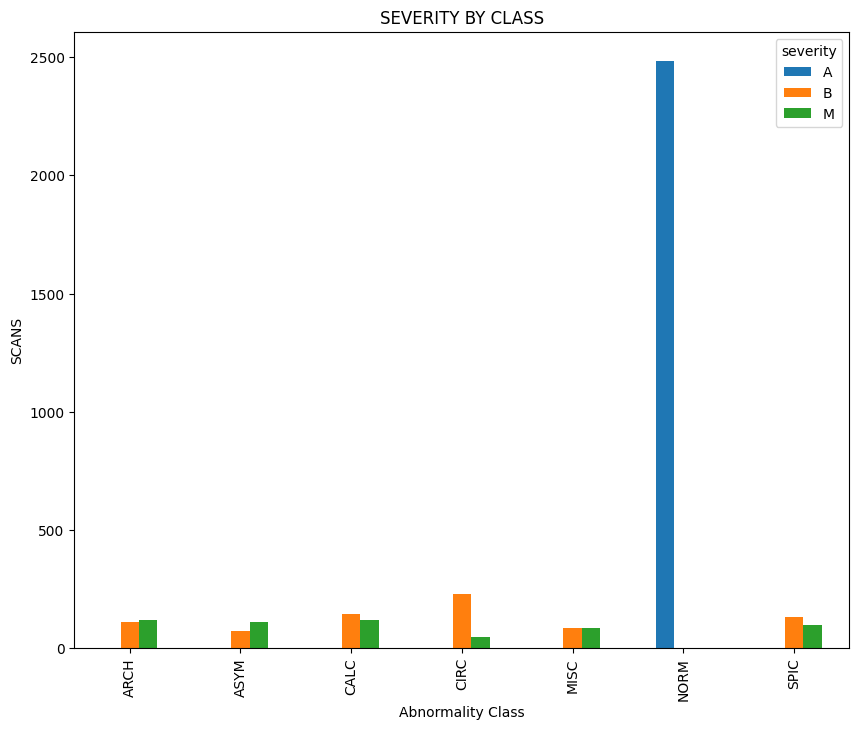

In [ ]:
mias.groupby(['ab_class', 'severity']).size().unstack().plot(kind='bar',
                                                               figsize=(10, 8),
                                                               xlabel='Abnormality Class',
                                                               ylabel='SCANS',
                                                               title='SEVERITY BY CLASS');

Abnormalities only

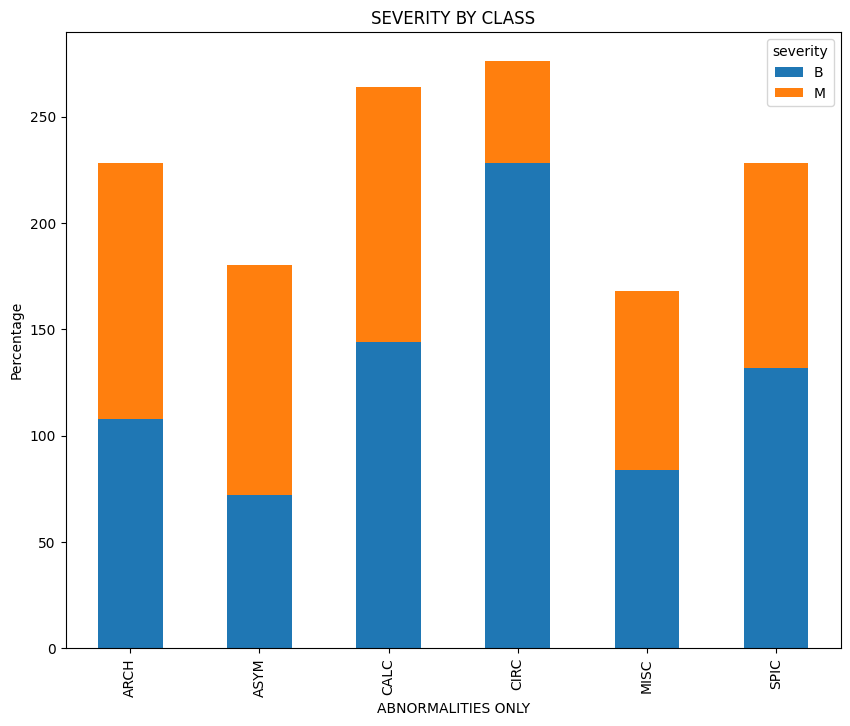

In [ ]:
mias[mias.ab_class != 'NORM'].groupby(['ab_class', 'severity']).size().unstack().plot(kind='bar',
                                                                                      stacked=True,
                                                                                      figsize=(10, 8),
                                                                                      xlabel='ABNORMALITIES ONLY',
                                                                                      ylabel='Percentage',
                                                                                      title='SEVERITY BY CLASS');

# Dataset balancing Example

### Calcifications before balancing

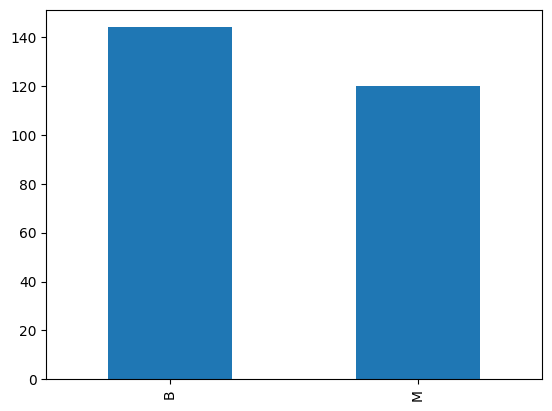

In [ ]:
calcifications_unbalanced = mias[mias.ab_class == 'CALC']

calcifications_unbalanced.severity.value_counts().plot(kind='bar');

Calcifications after balancing

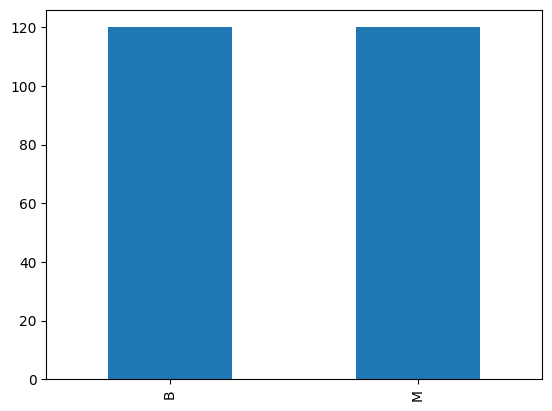

In [ ]:
calcifications_balanced = hp.balance_by_severity(mias, 'CALC')

calcifications_balanced.severity.value_counts().plot(kind='bar');

### Final Results Dataset

In [ ]:
final_results = hp.create_final_results_df()

# TRAIN AND EVALUATE MODEL FOR CALCIFICATIONS

In [ ]:
calcifications = hp.balance_by_severity(mias, 'CALC')
calcifications

ab_class bg severity                        subsample_path  \
mdb212_90_rotated      CALC  G        B   ../subsamples/mdb212_90_rotated.png   
mdb223_0_rotated       CALC  D        B    ../subsamples/mdb223_0_rotated.png   
mdb219_270_mirr_tp     CALC  G        B  ../subsamples/mdb219_270_mirr_tp.png   
mdb252_0_mirr_tp       CALC  F        B    ../subsamples/mdb252_0_mirr_tp.png   
mdb223_90_mirr_lr      CALC  D        B   ../subsamples/mdb223_90_mirr_lr.png   
...                     ... ..      ...                                   ...   
mdb256_180_mirr_lr     CALC  F        M  ../subsamples/mdb256_180_mirr_lr.png   
mdb256_180_mirr_tp     CALC  F        M  ../subsamples/mdb256_180_mirr_tp.png   
mdb256_270_rotated     CALC  F        M  ../subsamples/mdb256_270_rotated.png   
mdb256_270_mirr_lr     CALC  F        M  ../subsamples/mdb256_270_mirr_lr.png   
mdb256_270_mirr_tp     CALC  F        M  ../subsamples/mdb256_270_mirr_tp.png   

                                                             p_matrix  
mdb212_90_rotated   [[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,...  
mdb223_0_rotated    [[128, 127, 127, 130, 133, 131, 133, 133, 134,...  
mdb219_270_mirr_tp  [[161, 158, 153, 153, 153, 153, 150, 151, 150,...  
mdb252_0_mirr_tp    [[160, 162, 156, 156, 157, 152, 147, 150, 154,...  
mdb223_90_mirr_lr   [[165, 164, 165, 163, 162, 161, 161, 162, 159,...  
...                                                               ...  
mdb256_180_mirr_lr  [[160, 161, 161, 161, 161, 159, 157, 158, 161,...  
mdb256_180_mirr_tp  [[162, 159, 158, 160, 159, 161, 161, 161, 159,...  
mdb256_270_rotated  [[160, 160, 161, 159, 163, 165, 162, 159, 160,...  
mdb256_270_mirr_lr  [[173, 171, 169, 170, 173, 171, 167, 170, 168,...  
mdb256_270_mirr_tp  [[160, 161, 159, 159, 158, 157, 158, 162, 165,...  

[240 rows x 5 columns]

In [ ]:
calcifications = calcifications.sample(len(calcifications), replace=False)

### Generate Train and Test Data

In [ ]:
data_generator = ImageDataGenerator(validation_split=.25,
                                    height_shift_range=.10,
                                    width_shift_range=.10,
                                    rotation_range=30,
                                    rescale=1/255.)

# train data
train_data = data_generator.flow_from_dataframe(calcifications,
                                                x_col="subsample_path",
                                                y_col="severity",
                                                class_mode="categorical",
                                                target_size=(48,48),
                                                subset="training",
                                                color_mode="grayscale",
                                                shuffle=True)

# test data
test_data = data_generator.flow_from_dataframe(calcifications,
                                               x_col="subsample_path",
                                               y_col="severity",
                                               class_mode="categorical",
                                               target_size=(48,48),
                                               subset="validation",
                                               color_mode="grayscale",
                                               shuffle=False)

Found 180 validated image filenames belonging to 2 classes.
Found 60 validated image filenames belonging to 2 classes.


### Create Convolutional Neural Network

In [ ]:
cnn_calc = Sequential()
# first layer
cnn_calc.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(48, 48, 1)))
cnn_calc.add(Conv2D(64, kernel_size=(3,3),activation='relu'))
cnn_calc.add(MaxPool2D(pool_size=(2, 2)))

cnn_calc.add(Conv2D(64, kernel_size=(3,3),activation='relu'))
cnn_calc.add(MaxPool2D(pool_size=(2, 2)))
cnn_calc.add(Dropout(0.25))
# Add dense layer to reduce the number of features
cnn_calc.add(Dense(64, activation='relu'))
cnn_calc.add(Dropout(0.25))
# flattening results
cnn_calc.add(Flatten())
# Dense layer to produce final output
cnn_calc.add(Dense(2, activation='softmax'))
# print summary
cnn_calc.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 10, 10, 64)        0

### Visualise the Model's Structure

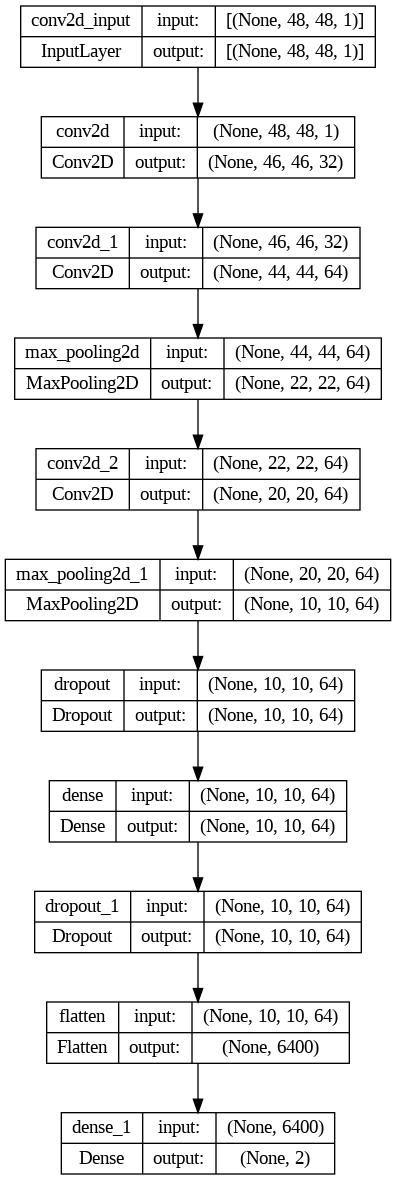

In [ ]:
plot_model(cnn_calc, to_file='convnet.png', show_shapes=True, show_layer_names=True)
Image(filename='convnet.png')

Compiling the model

In [ ]:
adam = Adam(0.001)
cnn_calc.compile(optimizer=adam,
            loss='categorical_crossentropy',
            metrics=['accuracy'])

Training and Evaluating the Model

In [ ]:
# set callbacks
early_stopping = EarlyStopping(patience=5000, restore_best_weights=True)


model_check_point = ModelCheckpoint(filepath= './',
                                    monitor='val_loss', verbose=1,
                                    save_best_only=True,
                                    save_weights_only=False,
                                    mode='auto', save_freq='epoch')

# fit the model
hist = cnn_calc.fit(train_data,
                    validation_data=test_data,
                    epochs=5000,
                    callbacks=[early_stopping, model_check_point])

Epoch 1/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.7185 - accuracy: 0.4865
Epoch 1: val_loss improved from inf to 0.69217, saving model to ./


6/6 [==============================] - 14s 460ms/step - loss: 0.7148 - accuracy: 0.4778 - val_loss: 0.6922 - val_accuracy: 0.5667
Epoch 2/5000
6/6 [==============================] - ETA: 0s - loss: 0.6935 - accuracy: 0.5444
Epoch 2: val_loss did not improve from 0.69217
6/6 [==============================] - 0s 41ms/step - loss: 0.6935 - accuracy: 0.5444 - val_loss: 0.6934 - val_accuracy: 0.5500
Epoch 3/5000
6/6 [==============================] - ETA: 0s - loss: 0.6923 - accuracy: 0.5500
Epoch 3: val_loss did not improve from 0.69217
6/6 [==============================] - 0s 39ms/step - loss: 0.6923 - accuracy: 0.5500 - val_loss: 0.6952 - val_accuracy: 0.5500
Epoch 4/5000
6/6 [==============================] - ETA: 0s - loss: 0.6929 - accuracy: 0.6000
Epoch 4: val_loss did not improve from 0.69217
6/6 [==============================] - 0s 62ms/step - loss: 0.6929 - accuracy: 0.6000 - val_loss: 0.7000 - val_accuracy: 0.5500
Epoch 5/5000
5/6 [========================>.....] - ETA: 0s - l

6/6 [==============================] - 2s 391ms/step - loss: 0.6876 - accuracy: 0.6000 - val_loss: 0.6912 - val_accuracy: 0.5500
Epoch 6/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.6867 - accuracy: 0.5946
Epoch 6: val_loss improved from 0.69123 to 0.68315, saving model to ./


6/6 [==============================] - 2s 343ms/step - loss: 0.6844 - accuracy: 0.6000 - val_loss: 0.6831 - val_accuracy: 0.5500
Epoch 7/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.6739 - accuracy: 0.6125
Epoch 7: val_loss improved from 0.68315 to 0.67566, saving model to ./


6/6 [==============================] - 2s 327ms/step - loss: 0.6780 - accuracy: 0.5944 - val_loss: 0.6757 - val_accuracy: 0.5500
Epoch 8/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.6665 - accuracy: 0.6062
Epoch 8: val_loss improved from 0.67566 to 0.63946, saving model to ./


6/6 [==============================] - 1s 273ms/step - loss: 0.6595 - accuracy: 0.5944 - val_loss: 0.6395 - val_accuracy: 0.5333
Epoch 9/5000
6/6 [==============================] - ETA: 0s - loss: 0.6555 - accuracy: 0.4500
Epoch 9: val_loss improved from 0.63946 to 0.61782, saving model to ./


6/6 [==============================] - 1s 275ms/step - loss: 0.6555 - accuracy: 0.4500 - val_loss: 0.6178 - val_accuracy: 0.5667
Epoch 10/5000
4/6 [===================>..........] - ETA: 0s - loss: 0.6508 - accuracy: 0.4828
Epoch 10: val_loss did not improve from 0.61782
6/6 [==============================] - 0s 38ms/step - loss: 0.6417 - accuracy: 0.5389 - val_loss: 0.6275 - val_accuracy: 0.5500
Epoch 11/5000
6/6 [==============================] - ETA: 0s - loss: 0.6388 - accuracy: 0.6000
Epoch 11: val_loss did not improve from 0.61782
6/6 [==============================] - 0s 42ms/step - loss: 0.6388 - accuracy: 0.6000 - val_loss: 0.6293 - val_accuracy: 0.5500
Epoch 12/5000
6/6 [==============================] - ETA: 0s - loss: 0.6333 - accuracy: 0.6000
Epoch 12: val_loss did not improve from 0.61782
6/6 [==============================] - 0s 40ms/step - loss: 0.6333 - accuracy: 0.6000 - val_loss: 0.6192 - val_accuracy: 0.5500
Epoch 13/5000
6/6 [==============================] - ETA: 

6/6 [==============================] - 1s 276ms/step - loss: 0.6332 - accuracy: 0.6000 - val_loss: 0.6163 - val_accuracy: 0.5500
Epoch 14/5000
6/6 [==============================] - ETA: 0s - loss: 0.6364 - accuracy: 0.5944
Epoch 14: val_loss improved from 0.61631 to 0.61479, saving model to ./


6/6 [==============================] - 1s 267ms/step - loss: 0.6364 - accuracy: 0.5944 - val_loss: 0.6148 - val_accuracy: 0.5500
Epoch 15/5000
6/6 [==============================] - ETA: 0s - loss: 0.6360 - accuracy: 0.5778
Epoch 15: val_loss did not improve from 0.61479
6/6 [==============================] - 0s 43ms/step - loss: 0.6360 - accuracy: 0.5778 - val_loss: 0.6166 - val_accuracy: 0.5500
Epoch 16/5000
6/6 [==============================] - ETA: 0s - loss: 0.6293 - accuracy: 0.6000
Epoch 16: val_loss did not improve from 0.61479
6/6 [==============================] - 0s 40ms/step - loss: 0.6293 - accuracy: 0.6000 - val_loss: 0.6279 - val_accuracy: 0.5500
Epoch 17/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.6371 - accuracy: 0.6149
Epoch 17: val_loss did not improve from 0.61479
6/6 [==============================] - 0s 44ms/step - loss: 0.6422 - accuracy: 0.6000 - val_loss: 0.6415 - val_accuracy: 0.5500
Epoch 18/5000
5/6 [========================>.....] - ETA: 

6/6 [==============================] - 2s 463ms/step - loss: 0.6319 - accuracy: 0.6000 - val_loss: 0.6146 - val_accuracy: 0.5500
Epoch 20/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.6363 - accuracy: 0.6081
Epoch 20: val_loss did not improve from 0.61463
6/6 [==============================] - 0s 76ms/step - loss: 0.6310 - accuracy: 0.6000 - val_loss: 0.6187 - val_accuracy: 0.5500
Epoch 21/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.6274 - accuracy: 0.6149
Epoch 21: val_loss did not improve from 0.61463
6/6 [==============================] - 0s 60ms/step - loss: 0.6302 - accuracy: 0.6000 - val_loss: 0.6244 - val_accuracy: 0.5500
Epoch 22/5000
6/6 [==============================] - ETA: 0s - loss: 0.6311 - accuracy: 0.6000
Epoch 22: val_loss did not improve from 0.61463
6/6 [==============================] - 0s 43ms/step - loss: 0.6311 - accuracy: 0.6000 - val_loss: 0.6187 - val_accuracy: 0.5500
Epoch 23/5000
6/6 [==============================] - ETA: 

6/6 [==============================] - 1s 262ms/step - loss: 0.6233 - accuracy: 0.6000 - val_loss: 0.6087 - val_accuracy: 0.5500
Epoch 28/5000
6/6 [==============================] - ETA: 0s - loss: 0.6231 - accuracy: 0.6000
Epoch 28: val_loss improved from 0.60871 to 0.60634, saving model to ./


6/6 [==============================] - 1s 275ms/step - loss: 0.6231 - accuracy: 0.6000 - val_loss: 0.6063 - val_accuracy: 0.5500
Epoch 29/5000
6/6 [==============================] - ETA: 0s - loss: 0.6128 - accuracy: 0.6000
Epoch 29: val_loss improved from 0.60634 to 0.59023, saving model to ./


6/6 [==============================] - 1s 267ms/step - loss: 0.6128 - accuracy: 0.6000 - val_loss: 0.5902 - val_accuracy: 0.7333
Epoch 30/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.6311 - accuracy: 0.6000
Epoch 30: val_loss improved from 0.59023 to 0.58987, saving model to ./


6/6 [==============================] - 2s 324ms/step - loss: 0.6269 - accuracy: 0.5833 - val_loss: 0.5899 - val_accuracy: 0.6333
Epoch 31/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.6365 - accuracy: 0.5750
Epoch 31: val_loss did not improve from 0.58987
6/6 [==============================] - 0s 42ms/step - loss: 0.6414 - accuracy: 0.5722 - val_loss: 0.6593 - val_accuracy: 0.5500
Epoch 32/5000
6/6 [==============================] - ETA: 0s - loss: 0.6306 - accuracy: 0.6056
Epoch 32: val_loss did not improve from 0.58987
6/6 [==============================] - 0s 42ms/step - loss: 0.6306 - accuracy: 0.6056 - val_loss: 0.6029 - val_accuracy: 0.5500
Epoch 33/5000
6/6 [==============================] - ETA: 0s - loss: 0.6172 - accuracy: 0.6111
Epoch 33: val_loss did not improve from 0.58987
6/6 [==============================] - 0s 43ms/step - loss: 0.6172 - accuracy: 0.6111 - val_loss: 0.6081 - val_accuracy: 0.5500
Epoch 34/5000
6/6 [==============================] - ETA: 

6/6 [==============================] - 1s 270ms/step - loss: 0.6085 - accuracy: 0.6333 - val_loss: 0.5799 - val_accuracy: 0.7333
Epoch 37/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.6222 - accuracy: 0.5676
Epoch 37: val_loss did not improve from 0.57991
6/6 [==============================] - 0s 53ms/step - loss: 0.6046 - accuracy: 0.6056 - val_loss: 0.6043 - val_accuracy: 0.6833
Epoch 38/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.6063 - accuracy: 0.6284
Epoch 38: val_loss improved from 0.57991 to 0.57768, saving model to ./


6/6 [==============================] - 2s 409ms/step - loss: 0.6124 - accuracy: 0.6111 - val_loss: 0.5777 - val_accuracy: 0.6000
Epoch 39/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.6282 - accuracy: 0.5811
Epoch 39: val_loss did not improve from 0.57768
6/6 [==============================] - 0s 65ms/step - loss: 0.6303 - accuracy: 0.5722 - val_loss: 0.5967 - val_accuracy: 0.5500
Epoch 40/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.6279 - accuracy: 0.6014
Epoch 40: val_loss did not improve from 0.57768
6/6 [==============================] - 0s 70ms/step - loss: 0.6256 - accuracy: 0.6000 - val_loss: 0.6291 - val_accuracy: 0.5500
Epoch 41/5000
6/6 [==============================] - ETA: 0s - loss: 0.6187 - accuracy: 0.6000
Epoch 41: val_loss did not improve from 0.57768
6/6 [==============================] - 0s 42ms/step - loss: 0.6187 - accuracy: 0.6000 - val_loss: 0.6008 - val_accuracy: 0.5500
Epoch 42/5000
5/6 [========================>.....] - ETA: 

6/6 [==============================] - 1s 264ms/step - loss: 0.5868 - accuracy: 0.6111 - val_loss: 0.5740 - val_accuracy: 0.5667
Epoch 51/5000
6/6 [==============================] - ETA: 0s - loss: 0.5732 - accuracy: 0.6778
Epoch 51: val_loss did not improve from 0.57401
6/6 [==============================] - 0s 41ms/step - loss: 0.5732 - accuracy: 0.6778 - val_loss: 0.6203 - val_accuracy: 0.6833
Epoch 52/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.5820 - accuracy: 0.5875
Epoch 52: val_loss improved from 0.57401 to 0.57275, saving model to ./


6/6 [==============================] - 2s 322ms/step - loss: 0.5835 - accuracy: 0.5944 - val_loss: 0.5728 - val_accuracy: 0.5667
Epoch 53/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.5858 - accuracy: 0.6284
Epoch 53: val_loss did not improve from 0.57275
6/6 [==============================] - 0s 42ms/step - loss: 0.5794 - accuracy: 0.6278 - val_loss: 0.5907 - val_accuracy: 0.7000
Epoch 54/5000
4/6 [===================>..........] - ETA: 0s - loss: 0.5911 - accuracy: 0.5948
Epoch 54: val_loss improved from 0.57275 to 0.56738, saving model to ./


6/6 [==============================] - 1s 271ms/step - loss: 0.5662 - accuracy: 0.6167 - val_loss: 0.5674 - val_accuracy: 0.6000
Epoch 55/5000
6/6 [==============================] - ETA: 0s - loss: 0.5759 - accuracy: 0.6000
Epoch 55: val_loss did not improve from 0.56738
6/6 [==============================] - 0s 40ms/step - loss: 0.5759 - accuracy: 0.6000 - val_loss: 0.5755 - val_accuracy: 0.5833
Epoch 56/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.5738 - accuracy: 0.6351
Epoch 56: val_loss did not improve from 0.56738
6/6 [==============================] - 0s 41ms/step - loss: 0.5679 - accuracy: 0.6500 - val_loss: 0.5850 - val_accuracy: 0.6167
Epoch 57/5000
6/6 [==============================] - ETA: 0s - loss: 0.5672 - accuracy: 0.6444
Epoch 57: val_loss did not improve from 0.56738
6/6 [==============================] - 0s 43ms/step - loss: 0.5672 - accuracy: 0.6444 - val_loss: 0.5916 - val_accuracy: 0.6000
Epoch 58/5000
6/6 [==============================] - ETA: 

6/6 [==============================] - 2s 403ms/step - loss: 0.5851 - accuracy: 0.5944 - val_loss: 0.5634 - val_accuracy: 0.6000
Epoch 66/5000
6/6 [==============================] - ETA: 0s - loss: 0.5759 - accuracy: 0.6389
Epoch 66: val_loss did not improve from 0.56336
6/6 [==============================] - 0s 40ms/step - loss: 0.5759 - accuracy: 0.6389 - val_loss: 0.6305 - val_accuracy: 0.6333
Epoch 67/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.5714 - accuracy: 0.6419
Epoch 67: val_loss did not improve from 0.56336
6/6 [==============================] - 0s 48ms/step - loss: 0.5691 - accuracy: 0.6389 - val_loss: 0.5687 - val_accuracy: 0.6333
Epoch 68/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.5559 - accuracy: 0.6689
Epoch 68: val_loss did not improve from 0.56336
6/6 [==============================] - 0s 44ms/step - loss: 0.5660 - accuracy: 0.6444 - val_loss: 0.5948 - val_accuracy: 0.6000
Epoch 69/5000
6/6 [==============================] - ETA: 

6/6 [==============================] - 1s 269ms/step - loss: 0.5343 - accuracy: 0.7000 - val_loss: 0.5588 - val_accuracy: 0.6333
Epoch 122/5000
6/6 [==============================] - ETA: 0s - loss: 0.5627 - accuracy: 0.7056
Epoch 122: val_loss did not improve from 0.55876
6/6 [==============================] - 0s 39ms/step - loss: 0.5627 - accuracy: 0.7056 - val_loss: 0.5904 - val_accuracy: 0.5500
Epoch 123/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.5268 - accuracy: 0.6562
Epoch 123: val_loss did not improve from 0.55876
6/6 [==============================] - 0s 40ms/step - loss: 0.5232 - accuracy: 0.6667 - val_loss: 0.5697 - val_accuracy: 0.6167
Epoch 124/5000
6/6 [==============================] - ETA: 0s - loss: 0.5257 - accuracy: 0.6667
Epoch 124: val_loss did not improve from 0.55876
6/6 [==============================] - 0s 41ms/step - loss: 0.5257 - accuracy: 0.6667 - val_loss: 0.6267 - val_accuracy: 0.6000
Epoch 125/5000
5/6 [========================>.....] 

6/6 [==============================] - 2s 317ms/step - loss: 0.5197 - accuracy: 0.6944 - val_loss: 0.5497 - val_accuracy: 0.6333
Epoch 131/5000
6/6 [==============================] - ETA: 0s - loss: 0.5242 - accuracy: 0.6889
Epoch 131: val_loss did not improve from 0.54966
6/6 [==============================] - 0s 60ms/step - loss: 0.5242 - accuracy: 0.6889 - val_loss: 0.5675 - val_accuracy: 0.6333
Epoch 132/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.5362 - accuracy: 0.6824
Epoch 132: val_loss did not improve from 0.54966
6/6 [==============================] - 0s 59ms/step - loss: 0.5286 - accuracy: 0.7000 - val_loss: 0.6034 - val_accuracy: 0.6167
Epoch 133/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.5496 - accuracy: 0.6562
Epoch 133: val_loss did not improve from 0.54966
6/6 [==============================] - 0s 75ms/step - loss: 0.5414 - accuracy: 0.6722 - val_loss: 0.6010 - val_accuracy: 0.6000
Epoch 134/5000
5/6 [========================>.....] 

6/6 [==============================] - 2s 329ms/step - loss: 0.5339 - accuracy: 0.6889 - val_loss: 0.5465 - val_accuracy: 0.6000
Epoch 143/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.5201 - accuracy: 0.6486
Epoch 143: val_loss did not improve from 0.54654
6/6 [==============================] - 0s 41ms/step - loss: 0.5190 - accuracy: 0.6611 - val_loss: 0.5909 - val_accuracy: 0.7000
Epoch 144/5000
6/6 [==============================] - ETA: 0s - loss: 0.5632 - accuracy: 0.6222
Epoch 144: val_loss did not improve from 0.54654
6/6 [==============================] - 0s 39ms/step - loss: 0.5632 - accuracy: 0.6222 - val_loss: 0.5672 - val_accuracy: 0.6167
Epoch 145/5000
6/6 [==============================] - ETA: 0s - loss: 0.5253 - accuracy: 0.7278
Epoch 145: val_loss did not improve from 0.54654
6/6 [==============================] - 0s 41ms/step - loss: 0.5253 - accuracy: 0.7278 - val_loss: 0.5615 - val_accuracy: 0.5500
Epoch 146/5000
5/6 [========================>.....] 

6/6 [==============================] - 1s 280ms/step - loss: 0.5104 - accuracy: 0.7167 - val_loss: 0.5294 - val_accuracy: 0.7000
Epoch 149/5000
6/6 [==============================] - ETA: 0s - loss: 0.5316 - accuracy: 0.7000
Epoch 149: val_loss did not improve from 0.52939
6/6 [==============================] - 0s 43ms/step - loss: 0.5316 - accuracy: 0.7000 - val_loss: 0.5905 - val_accuracy: 0.6167
Epoch 150/5000
6/6 [==============================] - ETA: 0s - loss: 0.5710 - accuracy: 0.6833
Epoch 150: val_loss did not improve from 0.52939
6/6 [==============================] - 0s 41ms/step - loss: 0.5710 - accuracy: 0.6833 - val_loss: 0.6930 - val_accuracy: 0.6500
Epoch 151/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.5503 - accuracy: 0.6622
Epoch 151: val_loss did not improve from 0.52939
6/6 [==============================] - 0s 43ms/step - loss: 0.5592 - accuracy: 0.6333 - val_loss: 0.5869 - val_accuracy: 0.6000
Epoch 152/5000
5/6 [========================>.....] 

6/6 [==============================] - 1s 274ms/step - loss: 0.4985 - accuracy: 0.6944 - val_loss: 0.5275 - val_accuracy: 0.6333
Epoch 187/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.5005 - accuracy: 0.6757
Epoch 187: val_loss did not improve from 0.52751
6/6 [==============================] - 0s 43ms/step - loss: 0.5213 - accuracy: 0.6611 - val_loss: 0.5928 - val_accuracy: 0.6167
Epoch 188/5000
6/6 [==============================] - ETA: 0s - loss: 0.5083 - accuracy: 0.6556
Epoch 188: val_loss did not improve from 0.52751
6/6 [==============================] - 0s 41ms/step - loss: 0.5083 - accuracy: 0.6556 - val_loss: 0.6135 - val_accuracy: 0.6167
Epoch 189/5000
6/6 [==============================] - ETA: 0s - loss: 0.5166 - accuracy: 0.6944
Epoch 189: val_loss did not improve from 0.52751
6/6 [==============================] - 0s 41ms/step - loss: 0.5166 - accuracy: 0.6944 - val_loss: 0.6109 - val_accuracy: 0.6333
Epoch 190/5000
6/6 [==============================] 

6/6 [==============================] - 2s 363ms/step - loss: 0.5019 - accuracy: 0.7111 - val_loss: 0.5245 - val_accuracy: 0.6167
Epoch 195/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.4708 - accuracy: 0.7375
Epoch 195: val_loss improved from 0.52450 to 0.51372, saving model to ./


6/6 [==============================] - 2s 384ms/step - loss: 0.4898 - accuracy: 0.7222 - val_loss: 0.5137 - val_accuracy: 0.6333
Epoch 196/5000
6/6 [==============================] - ETA: 0s - loss: 0.5124 - accuracy: 0.7111
Epoch 196: val_loss did not improve from 0.51372
6/6 [==============================] - 0s 39ms/step - loss: 0.5124 - accuracy: 0.7111 - val_loss: 0.5649 - val_accuracy: 0.7000
Epoch 197/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.4827 - accuracy: 0.6938
Epoch 197: val_loss did not improve from 0.51372
6/6 [==============================] - 0s 40ms/step - loss: 0.4909 - accuracy: 0.6944 - val_loss: 0.5598 - val_accuracy: 0.6667
Epoch 198/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.4704 - accuracy: 0.7375
Epoch 198: val_loss improved from 0.51372 to 0.48971, saving model to ./


6/6 [==============================] - 1s 277ms/step - loss: 0.4847 - accuracy: 0.7222 - val_loss: 0.4897 - val_accuracy: 0.7833
Epoch 199/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.4654 - accuracy: 0.7432
Epoch 199: val_loss did not improve from 0.48971
6/6 [==============================] - 0s 42ms/step - loss: 0.4784 - accuracy: 0.7278 - val_loss: 0.5539 - val_accuracy: 0.7333
Epoch 200/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.5538 - accuracy: 0.7188
Epoch 200: val_loss did not improve from 0.48971
6/6 [==============================] - 0s 39ms/step - loss: 0.5365 - accuracy: 0.7167 - val_loss: 0.5493 - val_accuracy: 0.6833
Epoch 201/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.4936 - accuracy: 0.7312
Epoch 201: val_loss did not improve from 0.48971
6/6 [==============================] - 0s 58ms/step - loss: 0.4880 - accuracy: 0.7389 - val_loss: 0.5458 - val_accuracy: 0.6833
Epoch 202/5000
5/6 [========================>.....] 

6/6 [==============================] - 2s 389ms/step - loss: 0.5220 - accuracy: 0.7111 - val_loss: 0.4642 - val_accuracy: 0.7667
Epoch 224/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.5070 - accuracy: 0.6892
Epoch 224: val_loss did not improve from 0.46418
6/6 [==============================] - 0s 74ms/step - loss: 0.4973 - accuracy: 0.6944 - val_loss: 0.5972 - val_accuracy: 0.6167
Epoch 225/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.5125 - accuracy: 0.7027
Epoch 225: val_loss did not improve from 0.46418
6/6 [==============================] - 0s 58ms/step - loss: 0.5257 - accuracy: 0.7056 - val_loss: 0.5424 - val_accuracy: 0.6333
Epoch 226/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.5702 - accuracy: 0.6892
Epoch 226: val_loss did not improve from 0.46418
6/6 [==============================] - 0s 62ms/step - loss: 0.5489 - accuracy: 0.6944 - val_loss: 0.5324 - val_accuracy: 0.7167
Epoch 227/5000
5/6 [========================>.....] 

6/6 [==============================] - 2s 386ms/step - loss: 0.4734 - accuracy: 0.7056 - val_loss: 0.4463 - val_accuracy: 0.8000
Epoch 264/5000
6/6 [==============================] - ETA: 0s - loss: 0.4754 - accuracy: 0.7444
Epoch 264: val_loss did not improve from 0.44629
6/6 [==============================] - 0s 73ms/step - loss: 0.4754 - accuracy: 0.7444 - val_loss: 0.5071 - val_accuracy: 0.7333
Epoch 265/5000
6/6 [==============================] - ETA: 0s - loss: 0.4715 - accuracy: 0.7389
Epoch 265: val_loss did not improve from 0.44629
6/6 [==============================] - 0s 59ms/step - loss: 0.4715 - accuracy: 0.7389 - val_loss: 0.4757 - val_accuracy: 0.7667
Epoch 266/5000
6/6 [==============================] - ETA: 0s - loss: 0.5150 - accuracy: 0.7167
Epoch 266: val_loss did not improve from 0.44629
6/6 [==============================] - 0s 42ms/step - loss: 0.5150 - accuracy: 0.7167 - val_loss: 0.4846 - val_accuracy: 0.7333
Epoch 267/5000
5/6 [========================>.....] 

6/6 [==============================] - 2s 325ms/step - loss: 0.4717 - accuracy: 0.7056 - val_loss: 0.4434 - val_accuracy: 0.7833
Epoch 289/5000
6/6 [==============================] - ETA: 0s - loss: 0.4764 - accuracy: 0.7167
Epoch 289: val_loss did not improve from 0.44345
6/6 [==============================] - 0s 40ms/step - loss: 0.4764 - accuracy: 0.7167 - val_loss: 0.4866 - val_accuracy: 0.8167
Epoch 290/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.4774 - accuracy: 0.7095
Epoch 290: val_loss did not improve from 0.44345
6/6 [==============================] - 0s 43ms/step - loss: 0.4672 - accuracy: 0.7278 - val_loss: 0.4902 - val_accuracy: 0.7833
Epoch 291/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.5134 - accuracy: 0.6959
Epoch 291: val_loss did not improve from 0.44345
6/6 [==============================] - 0s 43ms/step - loss: 0.4835 - accuracy: 0.7111 - val_loss: 0.4893 - val_accuracy: 0.7667
Epoch 292/5000
5/6 [========================>.....] 

6/6 [==============================] - 1s 275ms/step - loss: 0.4563 - accuracy: 0.7500 - val_loss: 0.4347 - val_accuracy: 0.7667
Epoch 317/5000
6/6 [==============================] - ETA: 0s - loss: 0.4568 - accuracy: 0.7389
Epoch 317: val_loss improved from 0.43474 to 0.41784, saving model to ./


6/6 [==============================] - 1s 265ms/step - loss: 0.4568 - accuracy: 0.7389 - val_loss: 0.4178 - val_accuracy: 0.7833
Epoch 318/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.4754 - accuracy: 0.7703
Epoch 318: val_loss did not improve from 0.41784
6/6 [==============================] - 0s 44ms/step - loss: 0.4738 - accuracy: 0.7556 - val_loss: 0.4850 - val_accuracy: 0.7500
Epoch 319/5000
6/6 [==============================] - ETA: 0s - loss: 0.4242 - accuracy: 0.7444
Epoch 319: val_loss did not improve from 0.41784
6/6 [==============================] - 0s 40ms/step - loss: 0.4242 - accuracy: 0.7444 - val_loss: 0.4194 - val_accuracy: 0.7833
Epoch 320/5000
6/6 [==============================] - ETA: 0s - loss: 0.4450 - accuracy: 0.7278
Epoch 320: val_loss did not improve from 0.41784
6/6 [==============================] - 0s 40ms/step - loss: 0.4450 - accuracy: 0.7278 - val_loss: 0.4926 - val_accuracy: 0.7500
Epoch 321/5000
5/6 [========================>.....] 

6/6 [==============================] - 2s 353ms/step - loss: 0.4584 - accuracy: 0.7667 - val_loss: 0.3923 - val_accuracy: 0.8333
Epoch 329/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.4425 - accuracy: 0.7635
Epoch 329: val_loss did not improve from 0.39226
6/6 [==============================] - 0s 71ms/step - loss: 0.4486 - accuracy: 0.7500 - val_loss: 0.5252 - val_accuracy: 0.7000
Epoch 330/5000
6/6 [==============================] - ETA: 0s - loss: 0.4800 - accuracy: 0.7222
Epoch 330: val_loss did not improve from 0.39226
6/6 [==============================] - 0s 74ms/step - loss: 0.4800 - accuracy: 0.7222 - val_loss: 0.4563 - val_accuracy: 0.6667
Epoch 331/5000
6/6 [==============================] - ETA: 0s - loss: 0.4552 - accuracy: 0.7389
Epoch 331: val_loss did not improve from 0.39226
6/6 [==============================] - 0s 66ms/step - loss: 0.4552 - accuracy: 0.7389 - val_loss: 0.5175 - val_accuracy: 0.7167
Epoch 332/5000
5/6 [========================>.....] 

6/6 [==============================] - 1s 274ms/step - loss: 0.4445 - accuracy: 0.7389 - val_loss: 0.3840 - val_accuracy: 0.8333
Epoch 349/5000
6/6 [==============================] - ETA: 0s - loss: 0.4450 - accuracy: 0.7667
Epoch 349: val_loss did not improve from 0.38396
6/6 [==============================] - 0s 40ms/step - loss: 0.4450 - accuracy: 0.7667 - val_loss: 0.4913 - val_accuracy: 0.7000
Epoch 350/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.4396 - accuracy: 0.7375
Epoch 350: val_loss did not improve from 0.38396
6/6 [==============================] - 0s 40ms/step - loss: 0.4490 - accuracy: 0.7333 - val_loss: 0.4975 - val_accuracy: 0.8167
Epoch 351/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.4641 - accuracy: 0.7188
Epoch 351: val_loss did not improve from 0.38396
6/6 [==============================] - 0s 40ms/step - loss: 0.4648 - accuracy: 0.7222 - val_loss: 0.5026 - val_accuracy: 0.7333
Epoch 352/5000
6/6 [==============================] 

6/6 [==============================] - 2s 341ms/step - loss: 0.3967 - accuracy: 0.8167 - val_loss: 0.3650 - val_accuracy: 0.8333
Epoch 382/5000
6/6 [==============================] - ETA: 0s - loss: 0.3866 - accuracy: 0.8167
Epoch 382: val_loss did not improve from 0.36504
6/6 [==============================] - 0s 42ms/step - loss: 0.3866 - accuracy: 0.8167 - val_loss: 0.5620 - val_accuracy: 0.7500
Epoch 383/5000
6/6 [==============================] - ETA: 0s - loss: 0.4111 - accuracy: 0.7833
Epoch 383: val_loss did not improve from 0.36504
6/6 [==============================] - 0s 41ms/step - loss: 0.4111 - accuracy: 0.7833 - val_loss: 0.4429 - val_accuracy: 0.7667
Epoch 384/5000
4/6 [===================>..........] - ETA: 0s - loss: 0.4234 - accuracy: 0.7931
Epoch 384: val_loss did not improve from 0.36504
6/6 [==============================] - 0s 40ms/step - loss: 0.3873 - accuracy: 0.8167 - val_loss: 0.4369 - val_accuracy: 0.7833
Epoch 385/5000
6/6 [==============================] 

6/6 [==============================] - 1s 276ms/step - loss: 0.4259 - accuracy: 0.7944 - val_loss: 0.3555 - val_accuracy: 0.8167
Epoch 388/5000
6/6 [==============================] - ETA: 0s - loss: 0.4172 - accuracy: 0.8222
Epoch 388: val_loss did not improve from 0.35547
6/6 [==============================] - 0s 44ms/step - loss: 0.4172 - accuracy: 0.8222 - val_loss: 0.4780 - val_accuracy: 0.7333
Epoch 389/5000
6/6 [==============================] - ETA: 0s - loss: 0.4602 - accuracy: 0.7778
Epoch 389: val_loss did not improve from 0.35547
6/6 [==============================] - 0s 42ms/step - loss: 0.4602 - accuracy: 0.7778 - val_loss: 0.4343 - val_accuracy: 0.8000
Epoch 390/5000
6/6 [==============================] - ETA: 0s - loss: 0.3948 - accuracy: 0.8333
Epoch 390: val_loss did not improve from 0.35547
6/6 [==============================] - 0s 42ms/step - loss: 0.3948 - accuracy: 0.8333 - val_loss: 0.4361 - val_accuracy: 0.7667
Epoch 391/5000
6/6 [==============================] 

6/6 [==============================] - 2s 391ms/step - loss: 0.4263 - accuracy: 0.7556 - val_loss: 0.3104 - val_accuracy: 0.8667
Epoch 397/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.4279 - accuracy: 0.7838
Epoch 397: val_loss did not improve from 0.31037
6/6 [==============================] - 0s 62ms/step - loss: 0.4167 - accuracy: 0.7722 - val_loss: 0.4622 - val_accuracy: 0.7500
Epoch 398/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.3986 - accuracy: 0.8000
Epoch 398: val_loss did not improve from 0.31037
6/6 [==============================] - 0s 40ms/step - loss: 0.3855 - accuracy: 0.8056 - val_loss: 0.3603 - val_accuracy: 0.8000
Epoch 399/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.3417 - accuracy: 0.8446
Epoch 399: val_loss improved from 0.31037 to 0.28504, saving model to ./


6/6 [==============================] - 1s 273ms/step - loss: 0.3576 - accuracy: 0.8278 - val_loss: 0.2850 - val_accuracy: 0.9500
Epoch 400/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.3977 - accuracy: 0.7750
Epoch 400: val_loss did not improve from 0.28504
6/6 [==============================] - 0s 40ms/step - loss: 0.4241 - accuracy: 0.7722 - val_loss: 0.3913 - val_accuracy: 0.8667
Epoch 401/5000
6/6 [==============================] - ETA: 0s - loss: 0.3845 - accuracy: 0.8278
Epoch 401: val_loss did not improve from 0.28504
6/6 [==============================] - 0s 41ms/step - loss: 0.3845 - accuracy: 0.8278 - val_loss: 0.3622 - val_accuracy: 0.8667
Epoch 402/5000
6/6 [==============================] - ETA: 0s - loss: 0.4272 - accuracy: 0.7722
Epoch 402: val_loss did not improve from 0.28504
6/6 [==============================] - 0s 43ms/step - loss: 0.4272 - accuracy: 0.7722 - val_loss: 0.5071 - val_accuracy: 0.7667
Epoch 403/5000
5/6 [========================>.....] 

6/6 [==============================] - 2s 344ms/step - loss: 0.3391 - accuracy: 0.8444 - val_loss: 0.2618 - val_accuracy: 0.8833
Epoch 507/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.3904 - accuracy: 0.7635
Epoch 507: val_loss did not improve from 0.26182
6/6 [==============================] - 0s 75ms/step - loss: 0.4099 - accuracy: 0.7611 - val_loss: 0.3139 - val_accuracy: 0.8667
Epoch 508/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.4155 - accuracy: 0.7625
Epoch 508: val_loss did not improve from 0.26182
6/6 [==============================] - 0s 60ms/step - loss: 0.4009 - accuracy: 0.7722 - val_loss: 0.6010 - val_accuracy: 0.7167
Epoch 509/5000
6/6 [==============================] - ETA: 0s - loss: 0.4035 - accuracy: 0.8111
Epoch 509: val_loss did not improve from 0.26182
6/6 [==============================] - 0s 65ms/step - loss: 0.4035 - accuracy: 0.8111 - val_loss: 0.2744 - val_accuracy: 0.8833
Epoch 510/5000
5/6 [========================>.....] 

6/6 [==============================] - 1s 268ms/step - loss: 0.3168 - accuracy: 0.8278 - val_loss: 0.2534 - val_accuracy: 0.9500
Epoch 615/5000
6/6 [==============================] - ETA: 0s - loss: 0.2754 - accuracy: 0.8833
Epoch 615: val_loss did not improve from 0.25344
6/6 [==============================] - 0s 41ms/step - loss: 0.2754 - accuracy: 0.8833 - val_loss: 0.3549 - val_accuracy: 0.8333
Epoch 616/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.2567 - accuracy: 0.8784
Epoch 616: val_loss did not improve from 0.25344
6/6 [==============================] - 0s 41ms/step - loss: 0.2789 - accuracy: 0.8556 - val_loss: 0.3117 - val_accuracy: 0.8167
Epoch 617/5000
6/6 [==============================] - ETA: 0s - loss: 0.3270 - accuracy: 0.8278
Epoch 617: val_loss did not improve from 0.25344
6/6 [==============================] - 0s 41ms/step - loss: 0.3270 - accuracy: 0.8278 - val_loss: 0.3463 - val_accuracy: 0.8167
Epoch 618/5000
5/6 [========================>.....] 

6/6 [==============================] - 2s 335ms/step - loss: 0.2748 - accuracy: 0.8667 - val_loss: 0.2491 - val_accuracy: 0.9000
Epoch 914/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.3211 - accuracy: 0.8581
Epoch 914: val_loss did not improve from 0.24911
6/6 [==============================] - 0s 46ms/step - loss: 0.3057 - accuracy: 0.8667 - val_loss: 0.4988 - val_accuracy: 0.7500
Epoch 915/5000
6/6 [==============================] - ETA: 0s - loss: 0.2615 - accuracy: 0.8944
Epoch 915: val_loss did not improve from 0.24911
6/6 [==============================] - 0s 43ms/step - loss: 0.2615 - accuracy: 0.8944 - val_loss: 0.4561 - val_accuracy: 0.7833
Epoch 916/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.3117 - accuracy: 0.8716
Epoch 916: val_loss did not improve from 0.24911
6/6 [==============================] - 0s 43ms/step - loss: 0.3163 - accuracy: 0.8444 - val_loss: 0.3297 - val_accuracy: 0.8000
Epoch 917/5000
6/6 [==============================] 

6/6 [==============================] - 1s 274ms/step - loss: 0.1919 - accuracy: 0.9000 - val_loss: 0.2207 - val_accuracy: 0.8833
Epoch 1200/5000
6/6 [==============================] - ETA: 0s - loss: 0.2054 - accuracy: 0.9167
Epoch 1200: val_loss did not improve from 0.22069
6/6 [==============================] - 0s 42ms/step - loss: 0.2054 - accuracy: 0.9167 - val_loss: 0.3465 - val_accuracy: 0.7833
Epoch 1201/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.2044 - accuracy: 0.9054
Epoch 1201: val_loss did not improve from 0.22069
6/6 [==============================] - 0s 43ms/step - loss: 0.1893 - accuracy: 0.9167 - val_loss: 0.3823 - val_accuracy: 0.8000
Epoch 1202/5000
6/6 [==============================] - ETA: 0s - loss: 0.1992 - accuracy: 0.9167
Epoch 1202: val_loss did not improve from 0.22069
6/6 [==============================] - 0s 43ms/step - loss: 0.1992 - accuracy: 0.9167 - val_loss: 0.3208 - val_accuracy: 0.7833
Epoch 1203/5000
6/6 [=========================

6/6 [==============================] - 2s 348ms/step - loss: 0.2153 - accuracy: 0.8944 - val_loss: 0.2015 - val_accuracy: 0.9000
Epoch 1217/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.1998 - accuracy: 0.9000
Epoch 1217: val_loss did not improve from 0.20147
6/6 [==============================] - 0s 72ms/step - loss: 0.2098 - accuracy: 0.8944 - val_loss: 0.2781 - val_accuracy: 0.8333
Epoch 1218/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.1913 - accuracy: 0.9054
Epoch 1218: val_loss did not improve from 0.20147
6/6 [==============================] - 0s 59ms/step - loss: 0.1984 - accuracy: 0.9111 - val_loss: 0.4455 - val_accuracy: 0.7333
Epoch 1219/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.2427 - accuracy: 0.8813
Epoch 1219: val_loss did not improve from 0.20147
6/6 [==============================] - 0s 55ms/step - loss: 0.2349 - accuracy: 0.8944 - val_loss: 0.3333 - val_accuracy: 0.8833
Epoch 1220/5000
5/6 [========================>

6/6 [==============================] - 1s 271ms/step - loss: 0.1886 - accuracy: 0.9111 - val_loss: 0.1923 - val_accuracy: 0.9333
Epoch 1232/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.2515 - accuracy: 0.8813
Epoch 1232: val_loss did not improve from 0.19227
6/6 [==============================] - 0s 38ms/step - loss: 0.2355 - accuracy: 0.8889 - val_loss: 0.3500 - val_accuracy: 0.8667
Epoch 1233/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.2667 - accuracy: 0.8851
Epoch 1233: val_loss did not improve from 0.19227
6/6 [==============================] - 0s 42ms/step - loss: 0.2607 - accuracy: 0.8833 - val_loss: 0.3850 - val_accuracy: 0.7833
Epoch 1234/5000
6/6 [==============================] - ETA: 0s - loss: 0.1798 - accuracy: 0.9278
Epoch 1234: val_loss did not improve from 0.19227
6/6 [==============================] - 0s 44ms/step - loss: 0.1798 - accuracy: 0.9278 - val_loss: 0.3858 - val_accuracy: 0.8000
Epoch 1235/5000
6/6 [=========================

6/6 [==============================] - 1s 272ms/step - loss: 0.1580 - accuracy: 0.9500 - val_loss: 0.1697 - val_accuracy: 0.9333
Epoch 1409/5000
6/6 [==============================] - ETA: 0s - loss: 0.1799 - accuracy: 0.9111
Epoch 1409: val_loss did not improve from 0.16973
6/6 [==============================] - 0s 42ms/step - loss: 0.1799 - accuracy: 0.9111 - val_loss: 0.3533 - val_accuracy: 0.8000
Epoch 1410/5000
6/6 [==============================] - ETA: 0s - loss: 0.2104 - accuracy: 0.9000
Epoch 1410: val_loss did not improve from 0.16973
6/6 [==============================] - 0s 40ms/step - loss: 0.2104 - accuracy: 0.9000 - val_loss: 0.4176 - val_accuracy: 0.7667
Epoch 1411/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.1280 - accuracy: 0.9527
Epoch 1411: val_loss did not improve from 0.16973
6/6 [==============================] - 0s 71ms/step - loss: 0.1405 - accuracy: 0.9389 - val_loss: 0.2702 - val_accuracy: 0.8333
Epoch 1412/5000
5/6 [========================>

6/6 [==============================] - 2s 344ms/step - loss: 0.1896 - accuracy: 0.9000 - val_loss: 0.1411 - val_accuracy: 0.9333
Epoch 1600/5000
6/6 [==============================] - ETA: 0s - loss: 0.2430 - accuracy: 0.9056
Epoch 1600: val_loss did not improve from 0.14110
6/6 [==============================] - 0s 43ms/step - loss: 0.2430 - accuracy: 0.9056 - val_loss: 0.7338 - val_accuracy: 0.7500
Epoch 1601/5000
6/6 [==============================] - ETA: 0s - loss: 0.2502 - accuracy: 0.8889
Epoch 1601: val_loss did not improve from 0.14110
6/6 [==============================] - 0s 42ms/step - loss: 0.2502 - accuracy: 0.8889 - val_loss: 0.4440 - val_accuracy: 0.8333
Epoch 1602/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.4395 - accuracy: 0.8514
Epoch 1602: val_loss did not improve from 0.14110
6/6 [==============================] - 0s 42ms/step - loss: 0.3853 - accuracy: 0.8722 - val_loss: 0.6774 - val_accuracy: 0.7667
Epoch 1603/5000
5/6 [========================>

6/6 [==============================] - 1s 274ms/step - loss: 0.1133 - accuracy: 0.9444 - val_loss: 0.1127 - val_accuracy: 0.9833
Epoch 1868/5000
6/6 [==============================] - ETA: 0s - loss: 0.1554 - accuracy: 0.9444
Epoch 1868: val_loss did not improve from 0.11268
6/6 [==============================] - 0s 41ms/step - loss: 0.1554 - accuracy: 0.9444 - val_loss: 0.2121 - val_accuracy: 0.8500
Epoch 1869/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.1054 - accuracy: 0.9625
Epoch 1869: val_loss did not improve from 0.11268
6/6 [==============================] - 0s 42ms/step - loss: 0.0978 - accuracy: 0.9667 - val_loss: 0.3396 - val_accuracy: 0.8167
Epoch 1870/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.0940 - accuracy: 0.9662
Epoch 1870: val_loss did not improve from 0.11268
6/6 [==============================] - 0s 44ms/step - loss: 0.0947 - accuracy: 0.9722 - val_loss: 0.4013 - val_accuracy: 0.8333
Epoch 1871/5000
6/6 [=========================

6/6 [==============================] - 1s 277ms/step - loss: 0.1294 - accuracy: 0.9444 - val_loss: 0.0931 - val_accuracy: 0.9667
Epoch 2216/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.1263 - accuracy: 0.9595
Epoch 2216: val_loss did not improve from 0.09306
6/6 [==============================] - 0s 44ms/step - loss: 0.1129 - accuracy: 0.9667 - val_loss: 0.3277 - val_accuracy: 0.8833
Epoch 2217/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.1105 - accuracy: 0.9595
Epoch 2217: val_loss did not improve from 0.09306
6/6 [==============================] - 0s 44ms/step - loss: 0.1133 - accuracy: 0.9556 - val_loss: 0.3968 - val_accuracy: 0.7833
Epoch 2218/5000
6/6 [==============================] - ETA: 0s - loss: 0.1901 - accuracy: 0.9167
Epoch 2218: val_loss did not improve from 0.09306
6/6 [==============================] - 0s 44ms/step - loss: 0.1901 - accuracy: 0.9167 - val_loss: 0.2200 - val_accuracy: 0.8667
Epoch 2219/5000
5/6 [========================>

Streaming output truncated to the last 5000 lines.
6/6 [==============================] - 0s 72ms/step - loss: 0.0649 - accuracy: 0.9722 - val_loss: 0.4110 - val_accuracy: 0.8333
Epoch 3685/5000
6/6 [==============================] - ETA: 0s - loss: 0.0806 - accuracy: 0.9722
Epoch 3685: val_loss did not improve from 0.06447
6/6 [==============================] - 0s 81ms/step - loss: 0.0806 - accuracy: 0.9722 - val_loss: 0.3644 - val_accuracy: 0.9167
Epoch 3686/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.0621 - accuracy: 0.9812
Epoch 3686: val_loss did not improve from 0.06447
6/6 [==============================] - 0s 72ms/step - loss: 0.0560 - accuracy: 0.9833 - val_loss: 0.3444 - val_accuracy: 0.8333
Epoch 3687/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.0496 - accuracy: 0.9730
Epoch 3687: val_loss did not improve from 0.06447
6/6 [==============================] - 0s 51ms/step - loss: 0.0654 - accuracy: 0.9722 - val_loss: 0.2982 - val_accuracy: 0.8

6/6 [==============================] - 2s 319ms/step - loss: 0.0634 - accuracy: 0.9667 - val_loss: 0.0627 - val_accuracy: 0.9833
Epoch 4935/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.0611 - accuracy: 0.9730
Epoch 4935: val_loss improved from 0.06268 to 0.04621, saving model to ./


6/6 [==============================] - 1s 271ms/step - loss: 0.0543 - accuracy: 0.9778 - val_loss: 0.0462 - val_accuracy: 1.0000
Epoch 4936/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.0327 - accuracy: 0.9865
Epoch 4936: val_loss did not improve from 0.04621
6/6 [==============================] - 0s 48ms/step - loss: 0.0318 - accuracy: 0.9889 - val_loss: 0.1793 - val_accuracy: 0.9667
Epoch 4937/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.0502 - accuracy: 0.9730
Epoch 4937: val_loss did not improve from 0.04621
6/6 [==============================] - 0s 43ms/step - loss: 0.0445 - accuracy: 0.9778 - val_loss: 0.1551 - val_accuracy: 0.9333
Epoch 4938/5000
5/6 [========================>.....] - ETA: 0s - loss: 0.0144 - accuracy: 1.0000
Epoch 4938: val_loss did not improve from 0.04621
6/6 [==============================] - 0s 43ms/step - loss: 0.0146 - accuracy: 1.0000 - val_loss: 0.1460 - val_accuracy: 0.9167
Epoch 4939/5000
6/6 [=========================

### Making predictions

In [ ]:
# predictions
predictions = cnn_calc.predict(test_data)
predicted = [np.argmax(w) for w in predictions]
expected = test_data.labels


# Evaluation Results
loss_value , accuracy = cnn_calc.evaluate(train_data)

print(f'Test loss_value: {loss_value}')
print(f'Test accuracy: {accuracy}')

6/6 [==============================] - 0s 22ms/step - loss: 0.1393 - accuracy: 0.9389
Test loss_value: 0.13926462829113007
Test accuracy: 0.9388889074325562


### Confusion Matrix

In [ ]:
confusion_matrix(expected, predicted)

array([[26,  8],
       [ 2, 24]])

### Classification Report

In [ ]:
# B, M or A
print(f'Classes: {test_data.class_indices}\n')
print(classification_report(expected, predicted))

Classes: {'B': 0, 'M': 1}

              precision    recall  f1-score   support

           0       0.93      0.76      0.84        34
           1       0.75      0.92      0.83        26

    accuracy                           0.83        60
   macro avg       0.84      0.84      0.83        60
weighted avg       0.85      0.83      0.83        60



### Results

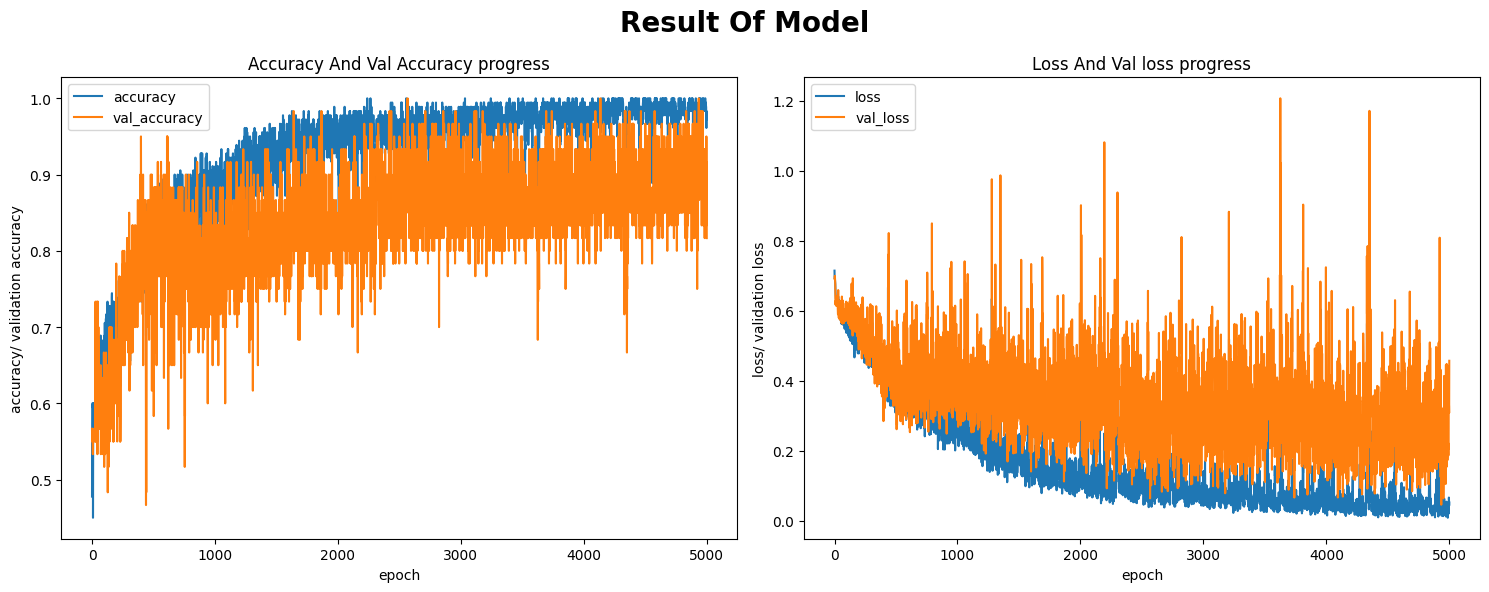

In [ ]:
results_plot = hp.plot_results(hist.history['accuracy'],
                            hist.history['val_accuracy'],
                            hist.history['loss'],
                            hist.history['val_loss'])

# enter data to the final results dataframe
results_calc = classification_report(expected, predicted, output_dict=True)

In [ ]:
calc_malignant = results_calc['1']
calc_malignant
final_results.loc['calcifications'] = (accuracy,
                                       calc_malignant['precision'],
                                       calc_malignant['recall'],
                                       calc_malignant['f1-score'])
final_results

test_accuracy  precision    recall  f1-score
calcifications       0.938889       0.75  0.923077  0.827586

### Checking Wrong Predictions

In [ ]:
# checking wrong predictions
wrong_predictions = []
images = calcifications.p_matrix
predictions = cnn_calc.predict(test_data)

for i, (p,e) in enumerate(zip(predictions, test_data.labels)):
    predicted, expected = np.argmax(p), np.argmax(e)

    if predicted != expected:
        wrong_predictions.append(
            (i, images[i], predicted, expected))

2/2 [==============================] - 0s 27ms/step


In [ ]:
len(wrong_predictions)

34

In [ ]:
a,b,c,d = wrong_predictions[4]

In [ ]:
hp.display_probabilities(predictions[4])

0: 0.0000000027%
1: 100.0000000000%


In [ ]:
test = calcifications.iloc[a].loc['p_matrix'] == b

In [ ]:
np.unique(test)

array([ True])

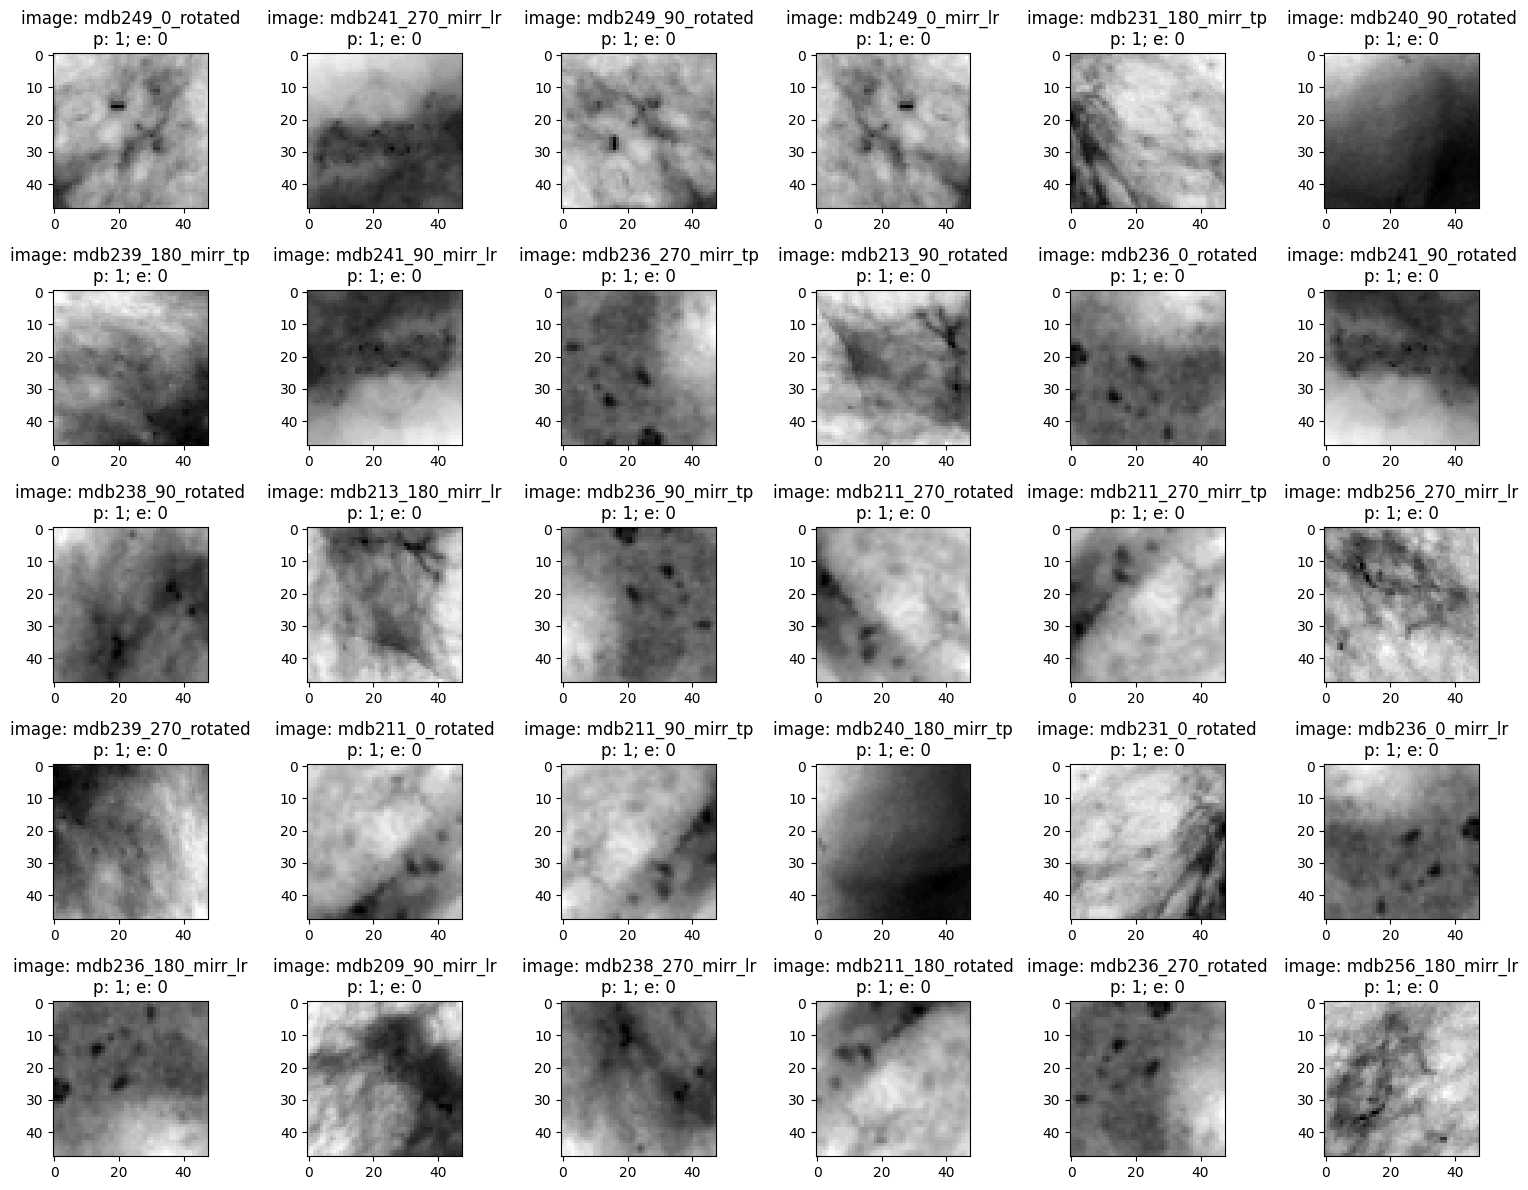

In [ ]:
figure, axes = plt.subplots(nrows=5, ncols=6, figsize=(16, 12))

for axes, item in zip(axes.ravel(), wrong_predictions):
    index, image, predicted, expected = item
    axes.imshow(image, cmap=plt.cm.gray_r)
    axes.set_title(
                    f'image: {calcifications.iloc[index].name}\np: {predicted}; e: {expected}'
                   )
    plt.tight_layout()

# TRAIN AND EVALUATE MODEL FOR MASSES (FULL BALANCE)

In [ ]:
# prepare dataset
circ_balanced = hp.balance_by_severity(mias, 'CIRC')
spic_balanced = hp.balance_by_severity(mias, 'SPIC')
misc_balanced = hp.balance_by_severity(mias, 'MISC')
# shuffle using the length of the smallest sample (CIRC)
circ_balanced = circ_balanced.sample(len(circ_balanced), replace=False)
spic_balanced = spic_balanced.sample(len(circ_balanced), replace=False)
misc_balanced = misc_balanced.sample(len(circ_balanced), replace=False)
# create new dataframe for the masses only
masses_balanced = pd.concat([circ_balanced, spic_balanced])
masses_balanced = pd.concat([masses_balanced, misc_balanced])
# masses dataset
masses_balanced = masses_balanced.sample(len(masses_balanced), replace=False)
masses_balanced

ab_class bg severity                        subsample_path  \
mdb028_180_mirr_tp     CIRC  F        M  ../subsamples/mdb028_180_mirr_tp.png   
mdb190_270_mirr_lr     SPIC  G        B  ../subsamples/mdb190_270_mirr_lr.png   
mdb312_180_mirr_tp     MISC  F        B  ../subsamples/mdb312_180_mirr_tp.png   
mdb134_90_mirr_tp      MISC  F        M   ../subsamples/mdb134_90_mirr_tp.png   
mdb206_0_rotated       SPIC  F        M    ../subsamples/mdb206_0_rotated.png   
...                     ... ..      ...                                   ...   
mdb134_90_mirr_lr      MISC  F        M   ../subsamples/mdb134_90_mirr_lr.png   
mdb315_180_mirr_lr     CIRC  D        B  ../subsamples/mdb315_180_mirr_lr.png   
mdb271_180_mirr_tp     MISC  F        M  ../subsamples/mdb271_180_mirr_tp.png   
mdb059_270_rotated     CIRC  F        B  ../subsamples/mdb059_270_rotated.png   
mdb063_180_rotated     MISC  D        B  ../subsamples/mdb063_180_rotated.png   

                                                             p_matrix  
mdb028_180_mirr_tp  [[123, 120, 121, 125, 131, 132, 138, 144, 145,...  
mdb190_270_mirr_lr  [[79, 78, 77, 76, 75, 75, 78, 80, 80, 79, 80, ...  
mdb312_180_mirr_tp  [[184, 185, 186, 185, 184, 184, 188, 190, 192,...  
mdb134_90_mirr_tp   [[142, 145, 146, 150, 151, 151, 154, 156, 156,...  
mdb206_0_rotated    [[142, 143, 144, 144, 142, 141, 141, 145, 149,...  
...                                                               ...  
mdb134_90_mirr_lr   [[143, 142, 142, 141, 141, 139, 137, 142, 145,...  
mdb315_180_mirr_lr  [[164, 164, 165, 164, 160, 162, 163, 166, 167,...  
mdb271_180_mirr_tp  [[0, 0, 0, 0, 11, 138, 160, 154, 150, 152, 153...  
mdb059_270_rotated  [[121, 113, 108, 108, 105, 101, 99, 99, 99, 10...  
mdb063_180_rotated  [[208, 210, 207, 207, 208, 208, 210, 207, 207,...  

[288 rows x 5 columns]

### Check Balancing

In [ ]:
masses_balanced.groupby('ab_class').severity.value_counts()

ab_class  severity
CIRC      B           48
          M           48
MISC      M           53
          B           43
SPIC      B           56
          M           40
Name: severity, dtype: int64

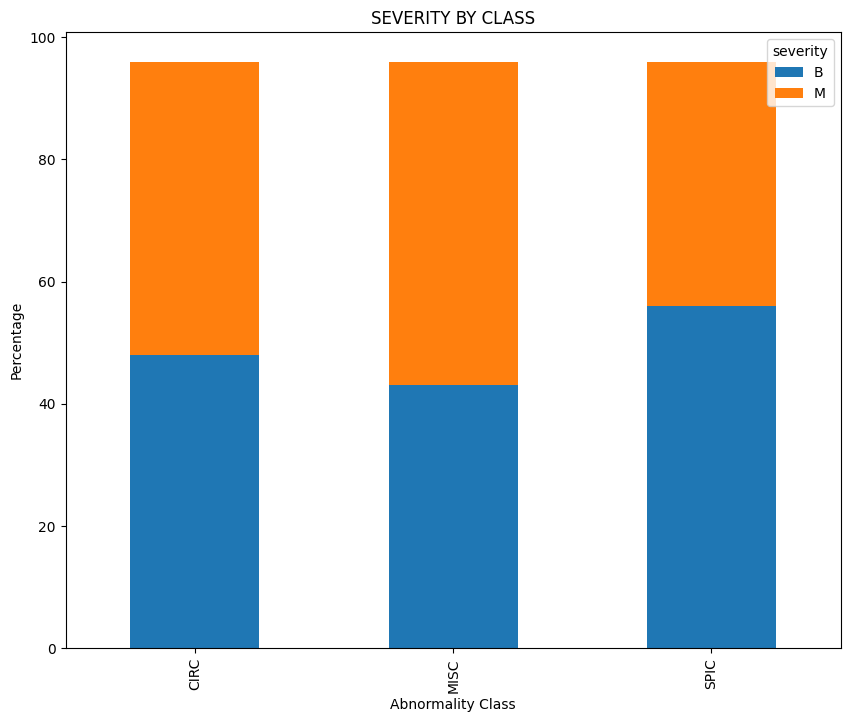

In [ ]:
masses_balanced.groupby(['ab_class', 'severity']).severity.size().unstack().plot(kind='bar',
                                                                      stacked=True,
                                                                      figsize=(10, 8),
                                                                      xlabel='Abnormality Class',
                                                                      ylabel='Percentage',
                                                                      title='SEVERITY BY CLASS');

### Generate Train and Test Data

In [ ]:
data_generator = ImageDataGenerator(validation_split=.25,
                                    height_shift_range=.10,
                                    width_shift_range=.10,
                                    rotation_range=30,
                                    rescale=1/255.)

train_data = data_generator.flow_from_dataframe(masses_balanced,
                                                x_col="subsample_path",
                                                y_col="severity",
                                                class_mode="categorical",
                                                target_size=(48,48),
                                                subset="training",
                                                color_mode="grayscale",
                                                shuffle=True)
test_data = data_generator.flow_from_dataframe(masses_balanced,
                                               x_col="subsample_path",
                                               y_col="severity",
                                               class_mode="categorical",
                                               target_size=(48,48),
                                               subset="validation",
                                               color_mode="grayscale",
                                               shuffle=False)

Found 216 validated image filenames belonging to 2 classes.
Found 72 validated image filenames belonging to 2 classes.


# Create Convolutional Neural Network

In [ ]:
mass_cnn = Sequential()
# first layer
mass_cnn.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(48, 48, 1)))
mass_cnn.add(Conv2D(64, kernel_size=(3,3),activation='relu'))
mass_cnn.add(MaxPool2D(pool_size=(2, 2)))

mass_cnn.add(Conv2D(64, kernel_size=(3,3),activation='relu'))
mass_cnn.add(MaxPool2D(pool_size=(2, 2)))
mass_cnn.add(Dropout(0.25))
# Add dense layer to reduce the number of features
mass_cnn.add(Dense(64, activation='relu'))
mass_cnn.add(Dropout(0.25))
# flattening results
mass_cnn.add(Flatten())
# Dense layer to produce final output
mass_cnn.add(Dense(2, activation='softmax'))
# print summary
mass_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 20, 20, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 10, 10, 64)       

### Visualise the Model's Structure

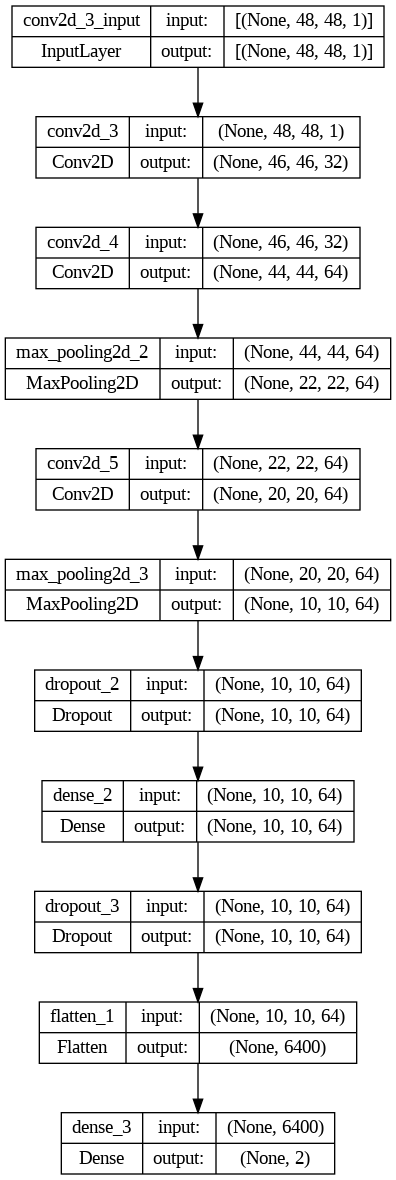

In [ ]:
plot_model(mass_cnn, to_file='convnet.png', show_shapes=True, show_layer_names=True)
Image(filename='convnet.png')

### Compiling the model

In [ ]:
# # set optmizer and learning rate
adam = Adam(0.001)
mass_cnn.compile(optimizer=adam,
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [ ]:
# set callbacks
early_stopping = EarlyStopping(patience=5000, restore_best_weights=True)


model_check_point = ModelCheckpoint(filepath= './',
                                    monitor='val_loss', verbose=1,
                                    save_best_only=True,
                                    save_weights_only=False,
                                    mode='auto', save_freq='epoch')

# fit the model
hist = mass_cnn.fit(train_data,
                    validation_data=test_data,
                    epochs=5000,
                    callbacks=[early_stopping, model_check_point])

Epoch 1/5000
6/7 [========================>.....] - ETA: 0s - loss: 0.6988 - accuracy: 0.5163
Epoch 1: val_loss improved from inf to 0.69275, saving model to ./


7/7 [==============================] - 6s 391ms/step - loss: 0.6999 - accuracy: 0.5000 - val_loss: 0.6927 - val_accuracy: 0.5278
Epoch 2/5000
6/7 [========================>.....] - ETA: 0s - loss: 0.6937 - accuracy: 0.4565
Epoch 2: val_loss did not improve from 0.69275
7/7 [==============================] - 0s 39ms/step - loss: 0.6942 - accuracy: 0.4537 - val_loss: 0.6938 - val_accuracy: 0.4722
Epoch 3/5000
6/7 [========================>.....] - ETA: 0s - loss: 0.6940 - accuracy: 0.5217
Epoch 3: val_loss did not improve from 0.69275
7/7 [==============================] - 0s 38ms/step - loss: 0.6963 - accuracy: 0.4907 - val_loss: 0.6941 - val_accuracy: 0.4722
Epoch 4/5000
7/7 [==============================] - ETA: 0s - loss: 0.6974 - accuracy: 0.4630
Epoch 4: val_loss improved from 0.69275 to 0.69198, saving model to ./


7/7 [==============================] - 1s 231ms/step - loss: 0.6974 - accuracy: 0.4630 - val_loss: 0.6920 - val_accuracy: 0.5278
Epoch 5/5000
6/7 [========================>.....] - ETA: 0s - loss: 0.6938 - accuracy: 0.5217
Epoch 5: val_loss did not improve from 0.69198
7/7 [==============================] - 0s 52ms/step - loss: 0.6943 - accuracy: 0.4954 - val_loss: 0.6930 - val_accuracy: 0.5278
Epoch 6/5000
5/7 [====================>.........] - ETA: 0s - loss: 0.6924 - accuracy: 0.5461
Epoch 6: val_loss did not improve from 0.69198
7/7 [==============================] - 0s 40ms/step - loss: 0.6927 - accuracy: 0.5278 - val_loss: 0.6929 - val_accuracy: 0.5278
Epoch 7/5000
7/7 [==============================] - ETA: 0s - loss: 0.6926 - accuracy: 0.5278
Epoch 7: val_loss did not improve from 0.69198
7/7 [==============================] - 0s 43ms/step - loss: 0.6926 - accuracy: 0.5278 - val_loss: 0.6929 - val_accuracy: 0.5278
Epoch 8/5000
7/7 [==============================] - ETA: 0s - lo

7/7 [==============================] - 1s 233ms/step - loss: 0.6813 - accuracy: 0.5139 - val_loss: 0.6910 - val_accuracy: 0.5278
Epoch 16/5000
6/7 [========================>.....] - ETA: 0s - loss: 0.6738 - accuracy: 0.5380
Epoch 16: val_loss improved from 0.69097 to 0.68477, saving model to ./


7/7 [==============================] - 2s 393ms/step - loss: 0.6791 - accuracy: 0.5139 - val_loss: 0.6848 - val_accuracy: 0.5556
Epoch 17/5000
7/7 [==============================] - ETA: 0s - loss: 0.6762 - accuracy: 0.5324
Epoch 17: val_loss did not improve from 0.68477
7/7 [==============================] - 0s 69ms/step - loss: 0.6762 - accuracy: 0.5324 - val_loss: 0.6876 - val_accuracy: 0.5417
Epoch 18/5000
7/7 [==============================] - ETA: 0s - loss: 0.6799 - accuracy: 0.5093
Epoch 18: val_loss did not improve from 0.68477
7/7 [==============================] - 0s 69ms/step - loss: 0.6799 - accuracy: 0.5093 - val_loss: 0.6913 - val_accuracy: 0.5417
Epoch 19/5000
7/7 [==============================] - ETA: 0s - loss: 0.6764 - accuracy: 0.5324
Epoch 19: val_loss improved from 0.68477 to 0.68431, saving model to ./


7/7 [==============================] - 2s 243ms/step - loss: 0.6764 - accuracy: 0.5324 - val_loss: 0.6843 - val_accuracy: 0.5556
Epoch 20/5000
7/7 [==============================] - ETA: 0s - loss: 0.6725 - accuracy: 0.5370
Epoch 20: val_loss did not improve from 0.68431
7/7 [==============================] - 0s 43ms/step - loss: 0.6725 - accuracy: 0.5370 - val_loss: 0.6916 - val_accuracy: 0.5556
Epoch 21/5000
6/7 [========================>.....] - ETA: 0s - loss: 0.6696 - accuracy: 0.5380
Epoch 21: val_loss did not improve from 0.68431
7/7 [==============================] - 0s 40ms/step - loss: 0.6726 - accuracy: 0.5324 - val_loss: 0.6878 - val_accuracy: 0.5556
Epoch 22/5000
6/7 [========================>.....] - ETA: 0s - loss: 0.6845 - accuracy: 0.5652
Epoch 22: val_loss improved from 0.68431 to 0.67734, saving model to ./


7/7 [==============================] - 1s 236ms/step - loss: 0.6762 - accuracy: 0.5694 - val_loss: 0.6773 - val_accuracy: 0.5694
Epoch 23/5000
7/7 [==============================] - ETA: 0s - loss: 0.6689 - accuracy: 0.5556
Epoch 23: val_loss did not improve from 0.67734
7/7 [==============================] - 0s 45ms/step - loss: 0.6689 - accuracy: 0.5556 - val_loss: 0.6883 - val_accuracy: 0.5833
Epoch 24/5000
7/7 [==============================] - ETA: 0s - loss: 0.6651 - accuracy: 0.5324
Epoch 24: val_loss did not improve from 0.67734
7/7 [==============================] - 0s 42ms/step - loss: 0.6651 - accuracy: 0.5324 - val_loss: 0.6818 - val_accuracy: 0.5278
Epoch 25/5000
5/7 [====================>.........] - ETA: 0s - loss: 0.6670 - accuracy: 0.5000
Epoch 25: val_loss did not improve from 0.67734
7/7 [==============================] - 0s 39ms/step - loss: 0.6667 - accuracy: 0.5463 - val_loss: 0.6779 - val_accuracy: 0.5972
Epoch 26/5000
7/7 [==============================] - ETA: 

7/7 [==============================] - 1s 235ms/step - loss: 0.6648 - accuracy: 0.5509 - val_loss: 0.6733 - val_accuracy: 0.5833
Epoch 27/5000
5/7 [====================>.........] - ETA: 0s - loss: 0.6783 - accuracy: 0.4868
Epoch 27: val_loss improved from 0.67329 to 0.65939, saving model to ./


7/7 [==============================] - 2s 248ms/step - loss: 0.6675 - accuracy: 0.5046 - val_loss: 0.6594 - val_accuracy: 0.5833
Epoch 28/5000
7/7 [==============================] - ETA: 0s - loss: 0.6646 - accuracy: 0.5602
Epoch 28: val_loss did not improve from 0.65939
7/7 [==============================] - 0s 44ms/step - loss: 0.6646 - accuracy: 0.5602 - val_loss: 0.6708 - val_accuracy: 0.5972
Epoch 29/5000
5/7 [====================>.........] - ETA: 0s - loss: 0.6695 - accuracy: 0.5500
Epoch 29: val_loss did not improve from 0.65939
7/7 [==============================] - 0s 42ms/step - loss: 0.6627 - accuracy: 0.5556 - val_loss: 0.6652 - val_accuracy: 0.5417
Epoch 30/5000
6/7 [========================>.....] - ETA: 0s - loss: 0.6686 - accuracy: 0.5217
Epoch 30: val_loss did not improve from 0.65939
7/7 [==============================] - 0s 40ms/step - loss: 0.6610 - accuracy: 0.5231 - val_loss: 0.6617 - val_accuracy: 0.5694
Epoch 31/5000
6/7 [========================>.....] - ETA: 

7/7 [==============================] - 2s 337ms/step - loss: 0.6482 - accuracy: 0.5741 - val_loss: 0.6497 - val_accuracy: 0.5972
Epoch 32/5000
7/7 [==============================] - ETA: 0s - loss: 0.6416 - accuracy: 0.5926
Epoch 32: val_loss improved from 0.64974 to 0.64160, saving model to ./


7/7 [==============================] - 2s 341ms/step - loss: 0.6416 - accuracy: 0.5926 - val_loss: 0.6416 - val_accuracy: 0.5972
Epoch 33/5000
6/7 [========================>.....] - ETA: 0s - loss: 0.6495 - accuracy: 0.5707
Epoch 33: val_loss did not improve from 0.64160
7/7 [==============================] - 0s 67ms/step - loss: 0.6516 - accuracy: 0.5694 - val_loss: 0.6563 - val_accuracy: 0.5833
Epoch 34/5000
5/7 [====================>.........] - ETA: 0s - loss: 0.6424 - accuracy: 0.5750
Epoch 34: val_loss improved from 0.64160 to 0.63497, saving model to ./


7/7 [==============================] - 1s 233ms/step - loss: 0.6492 - accuracy: 0.5602 - val_loss: 0.6350 - val_accuracy: 0.5972
Epoch 35/5000
7/7 [==============================] - ETA: 0s - loss: 0.6339 - accuracy: 0.5833
Epoch 35: val_loss improved from 0.63497 to 0.63389, saving model to ./


7/7 [==============================] - 1s 235ms/step - loss: 0.6339 - accuracy: 0.5833 - val_loss: 0.6339 - val_accuracy: 0.5972
Epoch 36/5000
7/7 [==============================] - ETA: 0s - loss: 0.6591 - accuracy: 0.5741
Epoch 36: val_loss did not improve from 0.63389
7/7 [==============================] - 0s 44ms/step - loss: 0.6591 - accuracy: 0.5741 - val_loss: 0.6444 - val_accuracy: 0.5972
Epoch 37/5000
6/7 [========================>.....] - ETA: 0s - loss: 0.6637 - accuracy: 0.5707
Epoch 37: val_loss did not improve from 0.63389
7/7 [==============================] - 0s 39ms/step - loss: 0.6607 - accuracy: 0.5880 - val_loss: 0.6419 - val_accuracy: 0.5000
Epoch 38/5000
5/7 [====================>.........] - ETA: 0s - loss: 0.6381 - accuracy: 0.6250
Epoch 38: val_loss did not improve from 0.63389
7/7 [==============================] - 0s 54ms/step - loss: 0.6371 - accuracy: 0.6296 - val_loss: 0.6383 - val_accuracy: 0.5694
Epoch 39/5000
5/7 [====================>.........] - ETA: 

7/7 [==============================] - 1s 235ms/step - loss: 0.6589 - accuracy: 0.5833 - val_loss: 0.6210 - val_accuracy: 0.6111
Epoch 46/5000
7/7 [==============================] - ETA: 0s - loss: 0.6341 - accuracy: 0.6065
Epoch 46: val_loss did not improve from 0.62098
7/7 [==============================] - 0s 55ms/step - loss: 0.6341 - accuracy: 0.6065 - val_loss: 0.6357 - val_accuracy: 0.6250
Epoch 47/5000
5/7 [====================>.........] - ETA: 0s - loss: 0.6444 - accuracy: 0.5875
Epoch 47: val_loss did not improve from 0.62098
7/7 [==============================] - 0s 40ms/step - loss: 0.6452 - accuracy: 0.5787 - val_loss: 0.6847 - val_accuracy: 0.6250
Epoch 48/5000
6/7 [========================>.....] - ETA: 0s - loss: 0.6272 - accuracy: 0.6304
Epoch 48: val_loss did not improve from 0.62098
7/7 [==============================] - 0s 40ms/step - loss: 0.6336 - accuracy: 0.6250 - val_loss: 0.6674 - val_accuracy: 0.5278
Epoch 49/5000
7/7 [==============================] - ETA: 

7/7 [==============================] - 1s 236ms/step - loss: 0.6095 - accuracy: 0.6343 - val_loss: 0.6179 - val_accuracy: 0.6806
Epoch 98/5000
6/7 [========================>.....] - ETA: 0s - loss: 0.6276 - accuracy: 0.6304
Epoch 98: val_loss improved from 0.61791 to 0.60570, saving model to ./


7/7 [==============================] - 2s 291ms/step - loss: 0.6187 - accuracy: 0.6343 - val_loss: 0.6057 - val_accuracy: 0.6250
Epoch 99/5000
7/7 [==============================] - ETA: 0s - loss: 0.6076 - accuracy: 0.6343
Epoch 99: val_loss did not improve from 0.60570
7/7 [==============================] - 0s 44ms/step - loss: 0.6076 - accuracy: 0.6343 - val_loss: 0.6336 - val_accuracy: 0.6389
Epoch 100/5000
7/7 [==============================] - ETA: 0s - loss: 0.6019 - accuracy: 0.6435
Epoch 100: val_loss did not improve from 0.60570
7/7 [==============================] - 0s 46ms/step - loss: 0.6019 - accuracy: 0.6435 - val_loss: 0.6403 - val_accuracy: 0.6111
Epoch 101/5000
5/7 [====================>.........] - ETA: 0s - loss: 0.6131 - accuracy: 0.6313
Epoch 101: val_loss did not improve from 0.60570
7/7 [==============================] - 0s 40ms/step - loss: 0.6290 - accuracy: 0.6481 - val_loss: 0.6415 - val_accuracy: 0.6250
Epoch 102/5000
7/7 [==============================] - 

7/7 [==============================] - 2s 294ms/step - loss: 0.5871 - accuracy: 0.6528 - val_loss: 0.5966 - val_accuracy: 0.6806
Epoch 118/5000
6/7 [========================>.....] - ETA: 0s - loss: 0.5913 - accuracy: 0.6739
Epoch 118: val_loss did not improve from 0.59656
7/7 [==============================] - 0s 43ms/step - loss: 0.5931 - accuracy: 0.6759 - val_loss: 0.6186 - val_accuracy: 0.5972
Epoch 119/5000
6/7 [========================>.....] - ETA: 0s - loss: 0.5880 - accuracy: 0.6630
Epoch 119: val_loss did not improve from 0.59656
7/7 [==============================] - 0s 43ms/step - loss: 0.6064 - accuracy: 0.6389 - val_loss: 0.6198 - val_accuracy: 0.6250
Epoch 120/5000
7/7 [==============================] - ETA: 0s - loss: 0.5918 - accuracy: 0.6528
Epoch 120: val_loss improved from 0.59656 to 0.58963, saving model to ./


7/7 [==============================] - 1s 237ms/step - loss: 0.5918 - accuracy: 0.6528 - val_loss: 0.5896 - val_accuracy: 0.6528
Epoch 121/5000
7/7 [==============================] - ETA: 0s - loss: 0.5935 - accuracy: 0.6759
Epoch 121: val_loss did not improve from 0.58963
7/7 [==============================] - 0s 41ms/step - loss: 0.5935 - accuracy: 0.6759 - val_loss: 0.6102 - val_accuracy: 0.6111
Epoch 122/5000
7/7 [==============================] - ETA: 0s - loss: 0.5954 - accuracy: 0.6343
Epoch 122: val_loss did not improve from 0.58963
7/7 [==============================] - 0s 43ms/step - loss: 0.5954 - accuracy: 0.6343 - val_loss: 0.6074 - val_accuracy: 0.6250
Epoch 123/5000
6/7 [========================>.....] - ETA: 0s - loss: 0.5496 - accuracy: 0.6793
Epoch 123: val_loss did not improve from 0.58963
7/7 [==============================] - 0s 54ms/step - loss: 0.5939 - accuracy: 0.6204 - val_loss: 0.6276 - val_accuracy: 0.6528
Epoch 124/5000
6/7 [========================>.....] 

7/7 [==============================] - 1s 236ms/step - loss: 0.5941 - accuracy: 0.6944 - val_loss: 0.5887 - val_accuracy: 0.6528
Epoch 132/5000
7/7 [==============================] - ETA: 0s - loss: 0.5883 - accuracy: 0.6713
Epoch 132: val_loss did not improve from 0.58870
7/7 [==============================] - 0s 61ms/step - loss: 0.5883 - accuracy: 0.6713 - val_loss: 0.6272 - val_accuracy: 0.6528
Epoch 133/5000
6/7 [========================>.....] - ETA: 0s - loss: 0.5687 - accuracy: 0.6771
Epoch 133: val_loss did not improve from 0.58870
7/7 [==============================] - 0s 60ms/step - loss: 0.5690 - accuracy: 0.6713 - val_loss: 0.6070 - val_accuracy: 0.6250
Epoch 134/5000
6/7 [========================>.....] - ETA: 0s - loss: 0.5793 - accuracy: 0.6739
Epoch 134: val_loss did not improve from 0.58870
7/7 [==============================] - 0s 61ms/step - loss: 0.5886 - accuracy: 0.6667 - val_loss: 0.5984 - val_accuracy: 0.6528
Epoch 135/5000
7/7 [==============================] 

7/7 [==============================] - 1s 239ms/step - loss: 0.5786 - accuracy: 0.6574 - val_loss: 0.5877 - val_accuracy: 0.6250
Epoch 143/5000
7/7 [==============================] - ETA: 0s - loss: 0.5887 - accuracy: 0.6852
Epoch 143: val_loss did not improve from 0.58772
7/7 [==============================] - 0s 56ms/step - loss: 0.5887 - accuracy: 0.6852 - val_loss: 0.5896 - val_accuracy: 0.6528
Epoch 144/5000
7/7 [==============================] - ETA: 0s - loss: 0.5846 - accuracy: 0.6806
Epoch 144: val_loss did not improve from 0.58772
7/7 [==============================] - 0s 43ms/step - loss: 0.5846 - accuracy: 0.6806 - val_loss: 0.6177 - val_accuracy: 0.6528
Epoch 145/5000
7/7 [==============================] - ETA: 0s - loss: 0.5958 - accuracy: 0.6343
Epoch 145: val_loss did not improve from 0.58772
7/7 [==============================] - 0s 42ms/step - loss: 0.5958 - accuracy: 0.6343 - val_loss: 0.6242 - val_accuracy: 0.6111
Epoch 146/5000
5/7 [====================>.........] 

7/7 [==============================] - 2s 300ms/step - loss: 0.5845 - accuracy: 0.6528 - val_loss: 0.5805 - val_accuracy: 0.6944
Epoch 150/5000
7/7 [==============================] - ETA: 0s - loss: 0.5868 - accuracy: 0.6667
Epoch 150: val_loss did not improve from 0.58047
7/7 [==============================] - 0s 38ms/step - loss: 0.5868 - accuracy: 0.6667 - val_loss: 0.6007 - val_accuracy: 0.6667
Epoch 151/5000
6/7 [========================>.....] - ETA: 0s - loss: 0.5935 - accuracy: 0.6576
Epoch 151: val_loss did not improve from 0.58047
7/7 [==============================] - 0s 40ms/step - loss: 0.5838 - accuracy: 0.6667 - val_loss: 0.6042 - val_accuracy: 0.6528
Epoch 152/5000
7/7 [==============================] - ETA: 0s - loss: 0.5813 - accuracy: 0.6574
Epoch 152: val_loss did not improve from 0.58047
7/7 [==============================] - 0s 55ms/step - loss: 0.5813 - accuracy: 0.6574 - val_loss: 0.5922 - val_accuracy: 0.6944
Epoch 153/5000
6/7 [========================>.....] 

7/7 [==============================] - 1s 234ms/step - loss: 0.5492 - accuracy: 0.7037 - val_loss: 0.5765 - val_accuracy: 0.6667
Epoch 177/5000
5/7 [====================>.........] - ETA: 0s - loss: 0.5501 - accuracy: 0.6750
Epoch 177: val_loss did not improve from 0.57652
7/7 [==============================] - 0s 41ms/step - loss: 0.5650 - accuracy: 0.6528 - val_loss: 0.5997 - val_accuracy: 0.6528
Epoch 178/5000
5/7 [====================>.........] - ETA: 0s - loss: 0.5823 - accuracy: 0.6382
Epoch 178: val_loss improved from 0.57652 to 0.57433, saving model to ./


7/7 [==============================] - 1s 232ms/step - loss: 0.5723 - accuracy: 0.6481 - val_loss: 0.5743 - val_accuracy: 0.6528
Epoch 179/5000
7/7 [==============================] - ETA: 0s - loss: 0.5643 - accuracy: 0.6713
Epoch 179: val_loss improved from 0.57433 to 0.57163, saving model to ./


7/7 [==============================] - 1s 235ms/step - loss: 0.5643 - accuracy: 0.6713 - val_loss: 0.5716 - val_accuracy: 0.6528
Epoch 180/5000
7/7 [==============================] - ETA: 0s - loss: 0.5749 - accuracy: 0.6667
Epoch 180: val_loss did not improve from 0.57163
7/7 [==============================] - 0s 42ms/step - loss: 0.5749 - accuracy: 0.6667 - val_loss: 0.5794 - val_accuracy: 0.6944
Epoch 181/5000
6/7 [========================>.....] - ETA: 0s - loss: 0.5633 - accuracy: 0.6848
Epoch 181: val_loss did not improve from 0.57163
7/7 [==============================] - 0s 40ms/step - loss: 0.5665 - accuracy: 0.6806 - val_loss: 0.5982 - val_accuracy: 0.5694
Epoch 182/5000
5/7 [====================>.........] - ETA: 0s - loss: 0.5566 - accuracy: 0.6776
Epoch 182: val_loss did not improve from 0.57163
7/7 [==============================] - 0s 42ms/step - loss: 0.5659 - accuracy: 0.6528 - val_loss: 0.5913 - val_accuracy: 0.6250
Epoch 183/5000
6/7 [========================>.....] 

7/7 [==============================] - 1s 230ms/step - loss: 0.5917 - accuracy: 0.6528 - val_loss: 0.5647 - val_accuracy: 0.7083
Epoch 195/5000
5/7 [====================>.........] - ETA: 0s - loss: 0.5568 - accuracy: 0.7039
Epoch 195: val_loss did not improve from 0.56470
7/7 [==============================] - 0s 42ms/step - loss: 0.5545 - accuracy: 0.6991 - val_loss: 0.5844 - val_accuracy: 0.6667
Epoch 196/5000
5/7 [====================>.........] - ETA: 0s - loss: 0.5571 - accuracy: 0.6750
Epoch 196: val_loss did not improve from 0.56470
7/7 [==============================] - 0s 40ms/step - loss: 0.5828 - accuracy: 0.6759 - val_loss: 0.6035 - val_accuracy: 0.6389
Epoch 197/5000
5/7 [====================>.........] - ETA: 0s - loss: 0.5877 - accuracy: 0.6579
Epoch 197: val_loss did not improve from 0.56470
7/7 [==============================] - 0s 53ms/step - loss: 0.5740 - accuracy: 0.6852 - val_loss: 0.6205 - val_accuracy: 0.6389
Epoch 198/5000
6/7 [========================>.....] 

7/7 [==============================] - 2s 315ms/step - loss: 0.5705 - accuracy: 0.6481 - val_loss: 0.5541 - val_accuracy: 0.7083
Epoch 210/5000
7/7 [==============================] - ETA: 0s - loss: 0.5643 - accuracy: 0.6759
Epoch 210: val_loss did not improve from 0.55414
7/7 [==============================] - 0s 61ms/step - loss: 0.5643 - accuracy: 0.6759 - val_loss: 0.5925 - val_accuracy: 0.6528
Epoch 211/5000
6/7 [========================>.....] - ETA: 0s - loss: 0.5726 - accuracy: 0.6413
Epoch 211: val_loss did not improve from 0.55414
7/7 [==============================] - 0s 67ms/step - loss: 0.5722 - accuracy: 0.6435 - val_loss: 0.5952 - val_accuracy: 0.6667
Epoch 212/5000
6/7 [========================>.....] - ETA: 0s - loss: 0.5438 - accuracy: 0.7174
Epoch 212: val_loss did not improve from 0.55414
7/7 [==============================] - 0s 72ms/step - loss: 0.5679 - accuracy: 0.6852 - val_loss: 0.6292 - val_accuracy: 0.6389
Epoch 213/5000
7/7 [==============================] 

7/7 [==============================] - 2s 247ms/step - loss: 0.5527 - accuracy: 0.6574 - val_loss: 0.5518 - val_accuracy: 0.7222
Epoch 256/5000
6/7 [========================>.....] - ETA: 0s - loss: 0.5184 - accuracy: 0.7120
Epoch 256: val_loss did not improve from 0.55181
7/7 [==============================] - 0s 43ms/step - loss: 0.5272 - accuracy: 0.7037 - val_loss: 0.5895 - val_accuracy: 0.6389
Epoch 257/5000
6/7 [========================>.....] - ETA: 0s - loss: 0.5073 - accuracy: 0.6793
Epoch 257: val_loss improved from 0.55181 to 0.53565, saving model to ./


7/7 [==============================] - 1s 237ms/step - loss: 0.5059 - accuracy: 0.6806 - val_loss: 0.5356 - val_accuracy: 0.7083
Epoch 258/5000
7/7 [==============================] - ETA: 0s - loss: 0.5362 - accuracy: 0.7083
Epoch 258: val_loss did not improve from 0.53565
7/7 [==============================] - 0s 55ms/step - loss: 0.5362 - accuracy: 0.7083 - val_loss: 0.5692 - val_accuracy: 0.7083
Epoch 259/5000
7/7 [==============================] - ETA: 0s - loss: 0.5394 - accuracy: 0.6759
Epoch 259: val_loss improved from 0.53565 to 0.52755, saving model to ./


7/7 [==============================] - 1s 234ms/step - loss: 0.5394 - accuracy: 0.6759 - val_loss: 0.5275 - val_accuracy: 0.7083
Epoch 260/5000
6/7 [========================>.....] - ETA: 0s - loss: 0.5503 - accuracy: 0.7120
Epoch 260: val_loss did not improve from 0.52755
7/7 [==============================] - 0s 41ms/step - loss: 0.5399 - accuracy: 0.7269 - val_loss: 0.5803 - val_accuracy: 0.6667
Epoch 261/5000
7/7 [==============================] - ETA: 0s - loss: 0.5685 - accuracy: 0.6667
Epoch 261: val_loss did not improve from 0.52755
7/7 [==============================] - 0s 44ms/step - loss: 0.5685 - accuracy: 0.6667 - val_loss: 0.5782 - val_accuracy: 0.6667
Epoch 262/5000
6/7 [========================>.....] - ETA: 0s - loss: 0.5239 - accuracy: 0.7011
Epoch 262: val_loss did not improve from 0.52755
7/7 [==============================] - 0s 52ms/step - loss: 0.5547 - accuracy: 0.6806 - val_loss: 0.5761 - val_accuracy: 0.6806
Epoch 263/5000
6/7 [========================>.....] 

7/7 [==============================] - 2s 286ms/step - loss: 0.5487 - accuracy: 0.6667 - val_loss: 0.5236 - val_accuracy: 0.6806
Epoch 269/5000
6/7 [========================>.....] - ETA: 0s - loss: 0.5002 - accuracy: 0.7446
Epoch 269: val_loss did not improve from 0.52363
7/7 [==============================] - 0s 39ms/step - loss: 0.5020 - accuracy: 0.7361 - val_loss: 0.5312 - val_accuracy: 0.6806
Epoch 270/5000
7/7 [==============================] - ETA: 0s - loss: 0.5204 - accuracy: 0.7269
Epoch 270: val_loss did not improve from 0.52363
7/7 [==============================] - 0s 40ms/step - loss: 0.5204 - accuracy: 0.7269 - val_loss: 0.5483 - val_accuracy: 0.6944
Epoch 271/5000
5/7 [====================>.........] - ETA: 0s - loss: 0.5698 - accuracy: 0.6375
Epoch 271: val_loss did not improve from 0.52363
7/7 [==============================] - 0s 41ms/step - loss: 0.5506 - accuracy: 0.6574 - val_loss: 0.5959 - val_accuracy: 0.6528
Epoch 272/5000
5/7 [====================>.........] 

7/7 [==============================] - 2s 291ms/step - loss: 0.5326 - accuracy: 0.7083 - val_loss: 0.5220 - val_accuracy: 0.7083
Epoch 275/5000
5/7 [====================>.........] - ETA: 0s - loss: 0.4733 - accuracy: 0.7937
Epoch 275: val_loss did not improve from 0.52195
7/7 [==============================] - 0s 39ms/step - loss: 0.5103 - accuracy: 0.7593 - val_loss: 0.5653 - val_accuracy: 0.6806
Epoch 276/5000
7/7 [==============================] - ETA: 0s - loss: 0.5235 - accuracy: 0.6944
Epoch 276: val_loss did not improve from 0.52195
7/7 [==============================] - 0s 43ms/step - loss: 0.5235 - accuracy: 0.6944 - val_loss: 0.5464 - val_accuracy: 0.7500
Epoch 277/5000
6/7 [========================>.....] - ETA: 0s - loss: 0.5471 - accuracy: 0.7065
Epoch 277: val_loss did not improve from 0.52195
7/7 [==============================] - 0s 39ms/step - loss: 0.5265 - accuracy: 0.7269 - val_loss: 0.6096 - val_accuracy: 0.6667
Epoch 278/5000
7/7 [==============================] 

7/7 [==============================] - 1s 236ms/step - loss: 0.5578 - accuracy: 0.6852 - val_loss: 0.5109 - val_accuracy: 0.7083
Epoch 280/5000
6/7 [========================>.....] - ETA: 0s - loss: 0.5452 - accuracy: 0.7120
Epoch 280: val_loss did not improve from 0.51091
7/7 [==============================] - 0s 39ms/step - loss: 0.5343 - accuracy: 0.7130 - val_loss: 0.5435 - val_accuracy: 0.7222
Epoch 281/5000
6/7 [========================>.....] - ETA: 0s - loss: 0.5191 - accuracy: 0.6957
Epoch 281: val_loss did not improve from 0.51091
7/7 [==============================] - 0s 53ms/step - loss: 0.5095 - accuracy: 0.7222 - val_loss: 0.5640 - val_accuracy: 0.7083
Epoch 282/5000
6/7 [========================>.....] - ETA: 0s - loss: 0.5024 - accuracy: 0.7283
Epoch 282: val_loss did not improve from 0.51091
7/7 [==============================] - 0s 57ms/step - loss: 0.5124 - accuracy: 0.7269 - val_loss: 0.5805 - val_accuracy: 0.6806
Epoch 283/5000
7/7 [==============================] 

7/7 [==============================] - 2s 298ms/step - loss: 0.5169 - accuracy: 0.6944 - val_loss: 0.5071 - val_accuracy: 0.7361
Epoch 287/5000
6/7 [========================>.....] - ETA: 0s - loss: 0.4837 - accuracy: 0.7228
Epoch 287: val_loss did not improve from 0.50706
7/7 [==============================] - 0s 40ms/step - loss: 0.4907 - accuracy: 0.7176 - val_loss: 0.5413 - val_accuracy: 0.6806
Epoch 288/5000
6/7 [========================>.....] - ETA: 0s - loss: 0.4824 - accuracy: 0.7228
Epoch 288: val_loss did not improve from 0.50706
7/7 [==============================] - 0s 38ms/step - loss: 0.4814 - accuracy: 0.7269 - val_loss: 0.5873 - val_accuracy: 0.6528
Epoch 289/5000
7/7 [==============================] - ETA: 0s - loss: 0.4805 - accuracy: 0.7361
Epoch 289: val_loss did not improve from 0.50706
7/7 [==============================] - 0s 41ms/step - loss: 0.4805 - accuracy: 0.7361 - val_loss: 0.5224 - val_accuracy: 0.6944
Epoch 290/5000
5/7 [====================>.........] 

7/7 [==============================] - 2s 340ms/step - loss: 0.5040 - accuracy: 0.7361 - val_loss: 0.4980 - val_accuracy: 0.7222
Epoch 317/5000
6/7 [========================>.....] - ETA: 0s - loss: 0.4728 - accuracy: 0.7337
Epoch 317: val_loss did not improve from 0.49801
7/7 [==============================] - 1s 73ms/step - loss: 0.4837 - accuracy: 0.7361 - val_loss: 0.5999 - val_accuracy: 0.6667
Epoch 318/5000
7/7 [==============================] - ETA: 0s - loss: 0.4901 - accuracy: 0.7731
Epoch 318: val_loss did not improve from 0.49801
7/7 [==============================] - 0s 71ms/step - loss: 0.4901 - accuracy: 0.7731 - val_loss: 0.5458 - val_accuracy: 0.7361
Epoch 319/5000
7/7 [==============================] - ETA: 0s - loss: 0.4981 - accuracy: 0.7361
Epoch 319: val_loss did not improve from 0.49801
7/7 [==============================] - 0s 56ms/step - loss: 0.4981 - accuracy: 0.7361 - val_loss: 0.5466 - val_accuracy: 0.6944
Epoch 320/5000
7/7 [==============================] 

7/7 [==============================] - 2s 299ms/step - loss: 0.4102 - accuracy: 0.8009 - val_loss: 0.4919 - val_accuracy: 0.7500
Epoch 449/5000
6/7 [========================>.....] - ETA: 0s - loss: 0.4271 - accuracy: 0.7826
Epoch 449: val_loss did not improve from 0.49194
7/7 [==============================] - 0s 41ms/step - loss: 0.4495 - accuracy: 0.7731 - val_loss: 0.6275 - val_accuracy: 0.7083
Epoch 450/5000
7/7 [==============================] - ETA: 0s - loss: 0.4861 - accuracy: 0.7500
Epoch 450: val_loss did not improve from 0.49194
7/7 [==============================] - 0s 43ms/step - loss: 0.4861 - accuracy: 0.7500 - val_loss: 0.6499 - val_accuracy: 0.6806
Epoch 451/5000
5/7 [====================>.........] - ETA: 0s - loss: 0.4938 - accuracy: 0.7500
Epoch 451: val_loss did not improve from 0.49194
7/7 [==============================] - 0s 41ms/step - loss: 0.4615 - accuracy: 0.7685 - val_loss: 0.5509 - val_accuracy: 0.7500
Epoch 452/5000
7/7 [==============================] 

7/7 [==============================] - 3s 412ms/step - loss: 0.5178 - accuracy: 0.7407 - val_loss: 0.4868 - val_accuracy: 0.7083
Epoch 475/5000
7/7 [==============================] - ETA: 0s - loss: 0.4664 - accuracy: 0.7407
Epoch 475: val_loss did not improve from 0.48677
7/7 [==============================] - 0s 67ms/step - loss: 0.4664 - accuracy: 0.7407 - val_loss: 0.5562 - val_accuracy: 0.7222
Epoch 476/5000
7/7 [==============================] - ETA: 0s - loss: 0.4665 - accuracy: 0.7407
Epoch 476: val_loss did not improve from 0.48677
7/7 [==============================] - 0s 70ms/step - loss: 0.4665 - accuracy: 0.7407 - val_loss: 0.6234 - val_accuracy: 0.6944
Epoch 477/5000
5/7 [====================>.........] - ETA: 0s - loss: 0.4311 - accuracy: 0.8313
Epoch 477: val_loss did not improve from 0.48677
7/7 [==============================] - 0s 41ms/step - loss: 0.4346 - accuracy: 0.8056 - val_loss: 0.5775 - val_accuracy: 0.7500
Epoch 478/5000
7/7 [==============================] 

7/7 [==============================] - 1s 235ms/step - loss: 0.4207 - accuracy: 0.7593 - val_loss: 0.4820 - val_accuracy: 0.7500
Epoch 491/5000
5/7 [====================>.........] - ETA: 0s - loss: 0.4818 - accuracy: 0.7500
Epoch 491: val_loss did not improve from 0.48201
7/7 [==============================] - 0s 40ms/step - loss: 0.4658 - accuracy: 0.7454 - val_loss: 0.6079 - val_accuracy: 0.6250
Epoch 492/5000
7/7 [==============================] - ETA: 0s - loss: 0.4412 - accuracy: 0.7778
Epoch 492: val_loss did not improve from 0.48201
7/7 [==============================] - 0s 42ms/step - loss: 0.4412 - accuracy: 0.7778 - val_loss: 0.5735 - val_accuracy: 0.6944
Epoch 493/5000
7/7 [==============================] - ETA: 0s - loss: 0.4915 - accuracy: 0.7315
Epoch 493: val_loss did not improve from 0.48201
7/7 [==============================] - 0s 44ms/step - loss: 0.4915 - accuracy: 0.7315 - val_loss: 0.5492 - val_accuracy: 0.7500
Epoch 494/5000
5/7 [====================>.........] 

7/7 [==============================] - 2s 243ms/step - loss: 0.4114 - accuracy: 0.8009 - val_loss: 0.4672 - val_accuracy: 0.7778
Epoch 607/5000
7/7 [==============================] - ETA: 0s - loss: 0.4012 - accuracy: 0.7870
Epoch 607: val_loss did not improve from 0.46719
7/7 [==============================] - 0s 55ms/step - loss: 0.4012 - accuracy: 0.7870 - val_loss: 0.6700 - val_accuracy: 0.7639
Epoch 608/5000
7/7 [==============================] - ETA: 0s - loss: 0.4282 - accuracy: 0.7500
Epoch 608: val_loss did not improve from 0.46719
7/7 [==============================] - 0s 44ms/step - loss: 0.4282 - accuracy: 0.7500 - val_loss: 0.5348 - val_accuracy: 0.7639
Epoch 609/5000
7/7 [==============================] - ETA: 0s - loss: 0.4160 - accuracy: 0.7778
Epoch 609: val_loss did not improve from 0.46719
7/7 [==============================] - 0s 42ms/step - loss: 0.4160 - accuracy: 0.7778 - val_loss: 0.5839 - val_accuracy: 0.7361
Epoch 610/5000
7/7 [==============================] 

7/7 [==============================] - 2s 307ms/step - loss: 0.4258 - accuracy: 0.8009 - val_loss: 0.4652 - val_accuracy: 0.7500
Epoch 651/5000
7/7 [==============================] - ETA: 0s - loss: 0.4099 - accuracy: 0.8009
Epoch 651: val_loss did not improve from 0.46517
7/7 [==============================] - 0s 44ms/step - loss: 0.4099 - accuracy: 0.8009 - val_loss: 0.6253 - val_accuracy: 0.7778
Epoch 652/5000
5/7 [====================>.........] - ETA: 0s - loss: 0.3979 - accuracy: 0.8125
Epoch 652: val_loss did not improve from 0.46517
7/7 [==============================] - 0s 41ms/step - loss: 0.4053 - accuracy: 0.7870 - val_loss: 0.6112 - val_accuracy: 0.7361
Epoch 653/5000
6/7 [========================>.....] - ETA: 0s - loss: 0.3704 - accuracy: 0.8043
Epoch 653: val_loss did not improve from 0.46517
7/7 [==============================] - 0s 42ms/step - loss: 0.3774 - accuracy: 0.7963 - val_loss: 0.6553 - val_accuracy: 0.7083
Epoch 654/5000
6/7 [========================>.....] 

7/7 [==============================] - 1s 235ms/step - loss: 0.3978 - accuracy: 0.7870 - val_loss: 0.4601 - val_accuracy: 0.7778
Epoch 813/5000
7/7 [==============================] - ETA: 0s - loss: 0.3600 - accuracy: 0.8009
Epoch 813: val_loss did not improve from 0.46015
7/7 [==============================] - 0s 47ms/step - loss: 0.3600 - accuracy: 0.8009 - val_loss: 0.5562 - val_accuracy: 0.7500
Epoch 814/5000
7/7 [==============================] - ETA: 0s - loss: 0.3368 - accuracy: 0.8102
Epoch 814: val_loss did not improve from 0.46015
7/7 [==============================] - 0s 43ms/step - loss: 0.3368 - accuracy: 0.8102 - val_loss: 0.6447 - val_accuracy: 0.7639
Epoch 815/5000
7/7 [==============================] - ETA: 0s - loss: 0.3555 - accuracy: 0.8287
Epoch 815: val_loss did not improve from 0.46015
7/7 [==============================] - 0s 43ms/step - loss: 0.3555 - accuracy: 0.8287 - val_loss: 0.7690 - val_accuracy: 0.6528
Epoch 816/5000
5/7 [====================>.........] 

7/7 [==============================] - 1s 233ms/step - loss: 0.3400 - accuracy: 0.8194 - val_loss: 0.4562 - val_accuracy: 0.7917
Epoch 900/5000
7/7 [==============================] - ETA: 0s - loss: 0.4235 - accuracy: 0.7963
Epoch 900: val_loss did not improve from 0.45616
7/7 [==============================] - 0s 56ms/step - loss: 0.4235 - accuracy: 0.7963 - val_loss: 0.7329 - val_accuracy: 0.7083
Epoch 901/5000
7/7 [==============================] - ETA: 0s - loss: 0.3711 - accuracy: 0.7870
Epoch 901: val_loss did not improve from 0.45616
7/7 [==============================] - 0s 67ms/step - loss: 0.3711 - accuracy: 0.7870 - val_loss: 0.5805 - val_accuracy: 0.7778
Epoch 902/5000
7/7 [==============================] - ETA: 0s - loss: 0.3597 - accuracy: 0.8241
Epoch 902: val_loss did not improve from 0.45616
7/7 [==============================] - 0s 68ms/step - loss: 0.3597 - accuracy: 0.8241 - val_loss: 0.4696 - val_accuracy: 0.8333
Epoch 903/5000
7/7 [==============================] 

7/7 [==============================] - 2s 244ms/step - loss: 0.3646 - accuracy: 0.7963 - val_loss: 0.4509 - val_accuracy: 0.7917
Epoch 954/5000
7/7 [==============================] - ETA: 0s - loss: 0.3611 - accuracy: 0.8241
Epoch 954: val_loss did not improve from 0.45090
7/7 [==============================] - 0s 43ms/step - loss: 0.3611 - accuracy: 0.8241 - val_loss: 0.6795 - val_accuracy: 0.7222
Epoch 955/5000
5/7 [====================>.........] - ETA: 0s - loss: 0.3045 - accuracy: 0.8562
Epoch 955: val_loss did not improve from 0.45090
7/7 [==============================] - 0s 42ms/step - loss: 0.3200 - accuracy: 0.8519 - val_loss: 0.5708 - val_accuracy: 0.7639
Epoch 956/5000
7/7 [==============================] - ETA: 0s - loss: 0.2776 - accuracy: 0.8889
Epoch 956: val_loss did not improve from 0.45090
7/7 [==============================] - 0s 43ms/step - loss: 0.2776 - accuracy: 0.8889 - val_loss: 0.6801 - val_accuracy: 0.7500
Epoch 957/5000
5/7 [====================>.........] 

7/7 [==============================] - 1s 237ms/step - loss: 0.3795 - accuracy: 0.7963 - val_loss: 0.4437 - val_accuracy: 0.7639
Epoch 1325/5000
7/7 [==============================] - ETA: 0s - loss: 0.3685 - accuracy: 0.8287
Epoch 1325: val_loss did not improve from 0.44367
7/7 [==============================] - 0s 43ms/step - loss: 0.3685 - accuracy: 0.8287 - val_loss: 0.5725 - val_accuracy: 0.7361
Epoch 1326/5000
7/7 [==============================] - ETA: 0s - loss: 0.3359 - accuracy: 0.8241
Epoch 1326: val_loss did not improve from 0.44367
7/7 [==============================] - 0s 43ms/step - loss: 0.3359 - accuracy: 0.8241 - val_loss: 0.5388 - val_accuracy: 0.7500
Epoch 1327/5000
7/7 [==============================] - ETA: 0s - loss: 0.3300 - accuracy: 0.8472
Epoch 1327: val_loss did not improve from 0.44367
7/7 [==============================] - 0s 56ms/step - loss: 0.3300 - accuracy: 0.8472 - val_loss: 0.5030 - val_accuracy: 0.7361
Epoch 1328/5000
7/7 [=========================

7/7 [==============================] - 3s 420ms/step - loss: 0.3454 - accuracy: 0.8472 - val_loss: 0.4395 - val_accuracy: 0.8056
Epoch 1340/5000
7/7 [==============================] - ETA: 0s - loss: 0.3485 - accuracy: 0.8287
Epoch 1340: val_loss did not improve from 0.43946
7/7 [==============================] - 0s 43ms/step - loss: 0.3485 - accuracy: 0.8287 - val_loss: 0.5659 - val_accuracy: 0.7778
Epoch 1341/5000
7/7 [==============================] - ETA: 0s - loss: 0.2848 - accuracy: 0.8519
Epoch 1341: val_loss did not improve from 0.43946
7/7 [==============================] - 0s 44ms/step - loss: 0.2848 - accuracy: 0.8519 - val_loss: 0.5543 - val_accuracy: 0.6528
Epoch 1342/5000
7/7 [==============================] - ETA: 0s - loss: 0.3493 - accuracy: 0.8287
Epoch 1342: val_loss did not improve from 0.43946
7/7 [==============================] - 0s 45ms/step - loss: 0.3493 - accuracy: 0.8287 - val_loss: 0.6068 - val_accuracy: 0.7083
Epoch 1343/5000
5/7 [====================>....

7/7 [==============================] - 2s 345ms/step - loss: 0.3489 - accuracy: 0.8148 - val_loss: 0.4155 - val_accuracy: 0.7500
Epoch 1360/5000
6/7 [========================>.....] - ETA: 0s - loss: 0.3491 - accuracy: 0.8424
Epoch 1360: val_loss did not improve from 0.41547
7/7 [==============================] - 0s 60ms/step - loss: 0.3519 - accuracy: 0.8426 - val_loss: 0.6495 - val_accuracy: 0.7083
Epoch 1361/5000
7/7 [==============================] - ETA: 0s - loss: 0.3354 - accuracy: 0.8333
Epoch 1361: val_loss did not improve from 0.41547
7/7 [==============================] - 0s 63ms/step - loss: 0.3354 - accuracy: 0.8333 - val_loss: 0.6395 - val_accuracy: 0.6806
Epoch 1362/5000
7/7 [==============================] - ETA: 0s - loss: 0.3433 - accuracy: 0.8611
Epoch 1362: val_loss did not improve from 0.41547
7/7 [==============================] - 0s 69ms/step - loss: 0.3433 - accuracy: 0.8611 - val_loss: 0.5717 - val_accuracy: 0.7083
Epoch 1363/5000
5/7 [====================>....

Streaming output truncated to the last 5000 lines.
Epoch 3751/5000
7/7 [==============================] - ETA: 0s - loss: 0.0964 - accuracy: 0.9630
Epoch 3751: val_loss did not improve from 0.41220
7/7 [==============================] - 1s 87ms/step - loss: 0.0964 - accuracy: 0.9630 - val_loss: 0.9324 - val_accuracy: 0.8056
Epoch 3752/5000
6/7 [========================>.....] - ETA: 0s - loss: 0.1129 - accuracy: 0.9565
Epoch 3752: val_loss did not improve from 0.41220
7/7 [==============================] - 1s 113ms/step - loss: 0.1093 - accuracy: 0.9583 - val_loss: 0.7840 - val_accuracy: 0.8472
Epoch 3753/5000
7/7 [==============================] - ETA: 0s - loss: 0.0890 - accuracy: 0.9676
Epoch 3753: val_loss did not improve from 0.41220
7/7 [==============================] - 1s 86ms/step - loss: 0.0890 - accuracy: 0.9676 - val_loss: 0.7171 - val_accuracy: 0.8750
Epoch 3754/5000
7/7 [==============================] - ETA: 0s - loss: 0.1179 - accuracy: 0.9630
Epoch 3754: val_loss did n

### Making Predictions

In [ ]:
# predictions
predictions = mass_cnn.predict(test_data)
predicted = [np.argmax(w) for w in predictions]
expected = test_data.labels


# Evaluation Results
loss_value , accuracy = mass_cnn.evaluate(train_data)

print(f'Test loss_value: {loss_value}')
print(f'Test accuracy: {accuracy}')

7/7 [==============================] - 0s 27ms/step - loss: 0.0683 - accuracy: 0.9769
Test loss_value: 0.06834451854228973
Test accuracy: 0.9768518805503845


### Confusion Matrix

In [ ]:
confusion_matrix(expected, predicted)

array([[34,  4],
       [ 7, 27]])

### Classification Report

In [ ]:
# B, M or A
print(f'Classes: {test_data.class_indices}\n')
print(classification_report(expected, predicted))

Classes: {'B': 0, 'M': 1}

              precision    recall  f1-score   support

           0       0.83      0.89      0.86        38
           1       0.87      0.79      0.83        34

    accuracy                           0.85        72
   macro avg       0.85      0.84      0.85        72
weighted avg       0.85      0.85      0.85        72



## Results

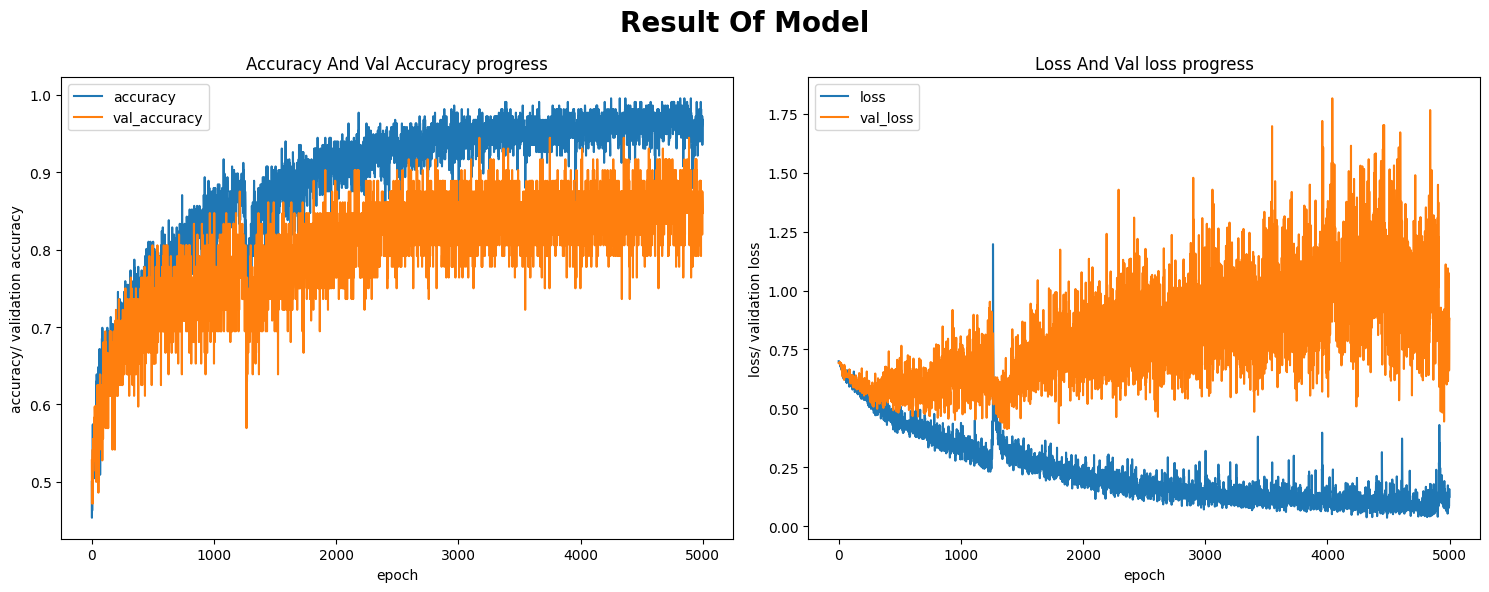

In [ ]:
results_plot = hp.plot_results(hist.history['accuracy'],
                               hist.history['val_accuracy'],
                               hist.history['loss'],
                               hist.history['val_loss'])

In [ ]:
# enter data to the final results dataframe
results_mass = classification_report(expected, predicted, output_dict=True)
# add entry to the final_results
mass_malignant = results_mass['1']
mass_malignant
final_results.loc['masses_full_bal'] = (accuracy,
                                       mass_malignant['precision'],
                                       mass_malignant['recall'],
                                       mass_malignant['f1-score'])
final_results

test_accuracy  precision    recall  f1-score
calcifications        0.938889   0.750000  0.923077  0.827586
masses_full_bal       0.976852   0.870968  0.794118  0.830769

# Checking Wrong Predictions

In [ ]:
# checking wrong predictions
predictions = mass_cnn.predict(test_data)

# check the probabilities for the first sample
for index, probability in enumerate(predictions[0]):
    print(f'{index}: {probability:.10%}')

3/3 [==============================] - 0s 16ms/step
0: 1.4584222808%
1: 98.5415756702%


In [ ]:
images = masses_balanced.p_matrix

In [ ]:
wrong_predictions = []

for i, (p,e) in enumerate(zip(predictions, test_data.labels)):
    predicted, expected = np.argmax(p), np.argmax(e)
    if predicted != expected:
        wrong_predictions.append(
            (i, images[i], predicted, expected))

In [ ]:
len(wrong_predictions)

34

In [ ]:
a,b,c,d = wrong_predictions[15]

In [ ]:
hp.display_probabilities(predictions[15])

0: 100.0000000000%
1: 0.0000000000%


In [ ]:
test = masses_balanced.iloc[a].loc['p_matrix'] == b

In [ ]:
np.unique(test)

array([ True])

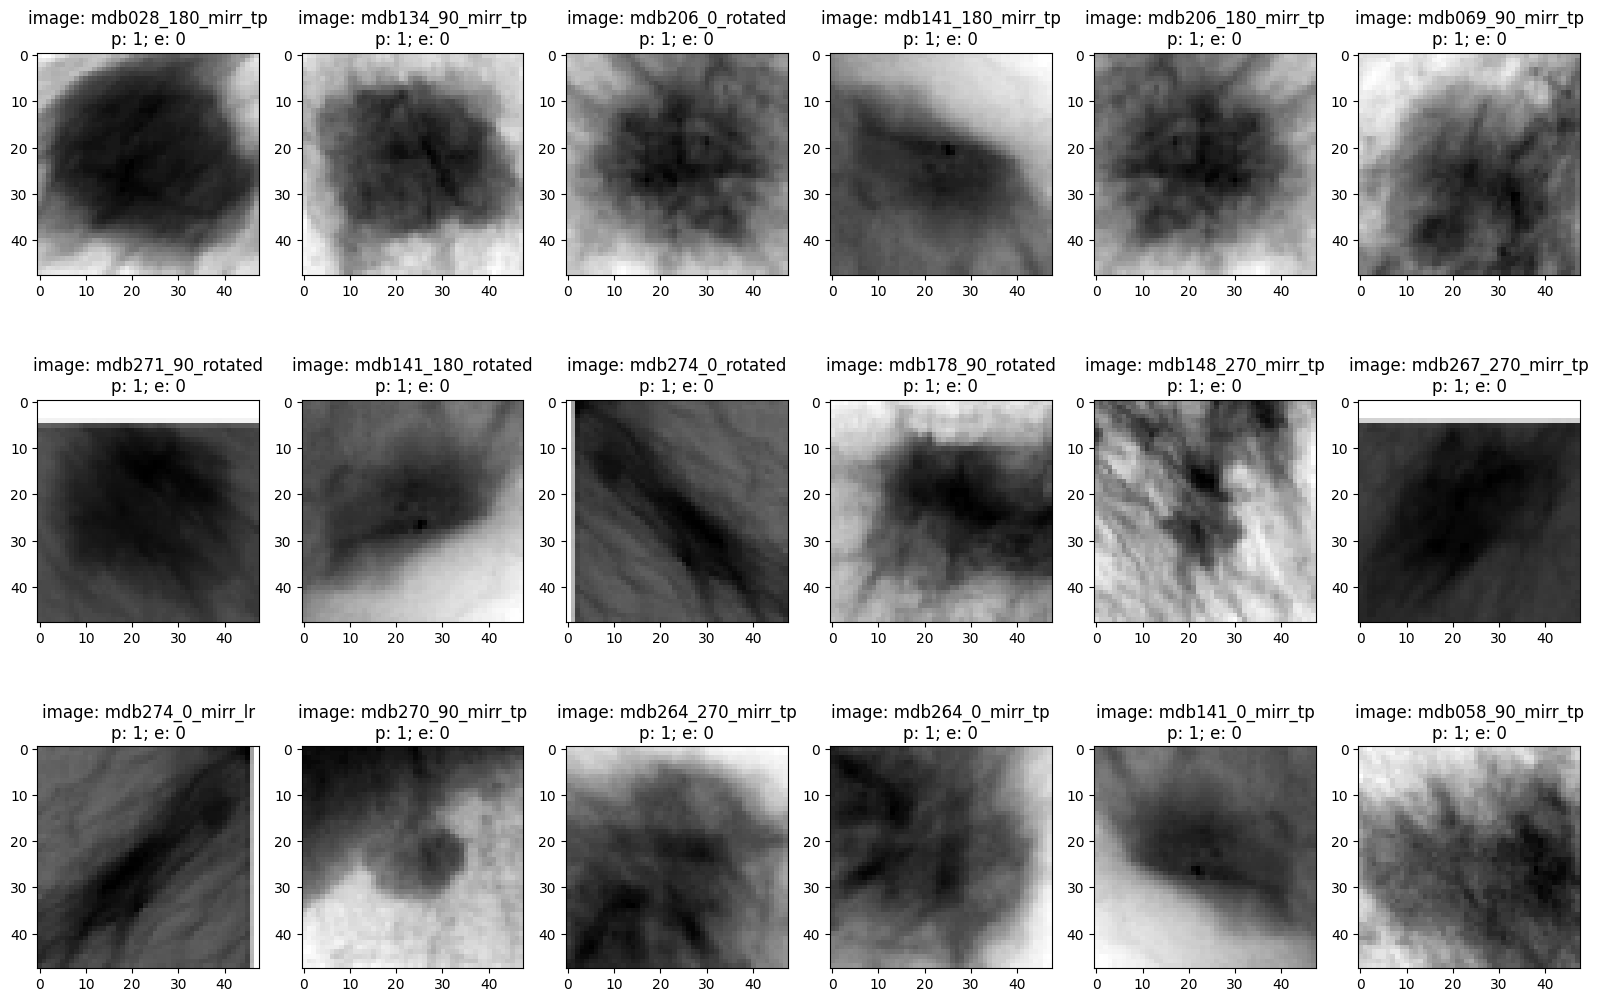

In [ ]:
figure, axes = plt.subplots(nrows=3, ncols=6, figsize=(16, 12))

for axes, item in zip(axes.ravel(), wrong_predictions):
    index, image, predicted, expected = item
    axes.imshow(image, cmap=plt.cm.gray_r)
    axes.set_title(
                    f'image: {masses_balanced.iloc[index].name}\np: {predicted}; e: {expected}'
                   )
    plt.tight_layout()

# TRAIN AND EVALUATE MODEL FOR ALL CLASSES (FULLY BALANCED)

In [ ]:
all_mias_full = hp.full_balance_df_by_severity(mias)
all_mias_full

ab_class bg severity                        subsample_path  \
mdb152_0_mirr_lr       ARCH  F        B    ../subsamples/mdb152_0_mirr_lr.png   
mdb248_90_mirr_tp      CALC  F        B   ../subsamples/mdb248_90_mirr_tp.png   
mdb270_180_rotated     CIRC  G        M  ../subsamples/mdb270_180_rotated.png   
mdb132_270_mirr_tp     CIRC  F        B  ../subsamples/mdb132_270_mirr_tp.png   
mdb218_180_rotated     CALC  G        B  ../subsamples/mdb218_180_rotated.png   
...                     ... ..      ...                                   ...   
mdb111_270_mirr_lr     ASYM  D        M  ../subsamples/mdb111_270_mirr_lr.png   
mdb032_270_mirr_tp     MISC  G        B  ../subsamples/mdb032_270_mirr_tp.png   
mdb305_0_mirr_lr       NORM  F        A    ../subsamples/mdb305_0_mirr_lr.png   
mdb141_0_mirr_tp       CIRC  F        M    ../subsamples/mdb141_0_mirr_tp.png   
mdb209_0_rotated       CALC  G        M    ../subsamples/mdb209_0_rotated.png   

                                                             p_matrix  
mdb152_0_mirr_lr    [[202, 203, 202, 202, 201, 201, 200, 201, 201,...  
mdb248_90_mirr_tp   [[168, 169, 172, 175, 176, 176, 176, 175, 175,...  
mdb270_180_rotated  [[132, 133, 136, 133, 135, 139, 138, 135, 140,...  
mdb132_270_mirr_tp  [[140, 137, 136, 133, 132, 131, 134, 140, 142,...  
mdb218_180_rotated  [[179, 179, 180, 181, 181, 181, 180, 179, 178,...  
...                                                               ...  
mdb111_270_mirr_lr  [[40, 43, 45, 46, 49, 52, 53, 56, 62, 65, 73, ...  
mdb032_270_mirr_tp  [[189, 192, 199, 203, 201, 194, 192, 187, 175,...  
mdb305_0_mirr_lr    [[130, 130, 132, 128, 124, 124, 123, 123, 123,...  
mdb141_0_mirr_tp    [[146, 149, 155, 160, 156, 148, 143, 138, 137,...  
mdb209_0_rotated    [[204, 200, 198, 195, 189, 186, 190, 195, 198,...  

[672 rows x 5 columns]

### Check Balancing

In [ ]:
all_mias_full.groupby('ab_class').severity.value_counts()

ab_class  severity
ARCH      B           48
          M           48
ASYM      B           48
          M           48
CALC      B           48
          M           48
CIRC      B           48
          M           48
MISC      B           48
          M           48
NORM      A           96
SPIC      B           48
          M           48
Name: severity, dtype: int64

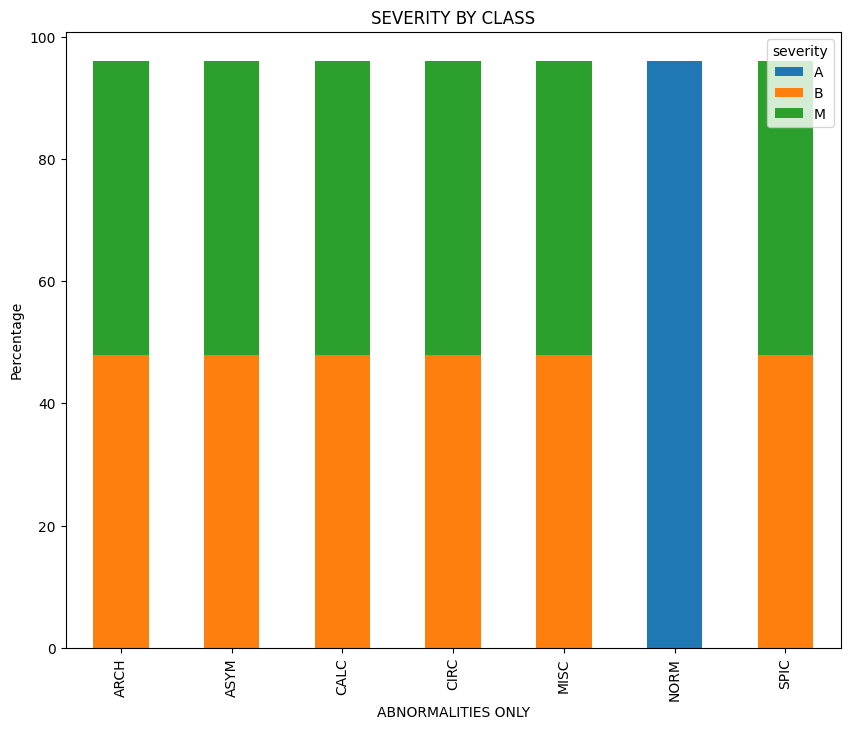

In [ ]:
all_mias_full.groupby(['ab_class', 'severity']).size().unstack().plot(kind='bar',
                                                              stacked=True,
                                                              figsize=(10, 8),
                                                              xlabel='ABNORMALITIES ONLY',
                                                              ylabel='Percentage',
                                                              title='SEVERITY BY CLASS');

### Generate Train and Test Data

In [ ]:
data_generator = ImageDataGenerator(validation_split=.25,
                                    height_shift_range=.10,
                                    width_shift_range=.10,
                                    rotation_range=30,
                                    rescale=1/255.)

train_data = data_generator.flow_from_dataframe(all_mias_full,
                                                x_col="subsample_path",
                                                y_col="severity",
                                                class_mode="categorical",
                                                target_size=(48,48),
                                                subset="training",
                                                color_mode="grayscale",
                                                shuffle=True)
test_data = data_generator.flow_from_dataframe(all_mias_full,
                                               x_col="subsample_path",
                                               y_col="severity",
                                               class_mode="categorical",
                                               target_size=(48,48),
                                               subset="validation",
                                               color_mode="grayscale",
                                               shuffle=False)

Found 504 validated image filenames belonging to 3 classes.
Found 168 validated image filenames belonging to 3 classes.


# Create Convolutional Neural Network

In [ ]:
all_mias = Sequential()
# first layer
all_mias.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(48, 48, 1)))
all_mias.add(Conv2D(64, kernel_size=(3,3),activation='relu'))
all_mias.add(MaxPool2D(pool_size=(2, 2)))

all_mias.add(Conv2D(64, kernel_size=(3,3),activation='relu'))
all_mias.add(MaxPool2D(pool_size=(2, 2)))
all_mias.add(Dropout(0.25))
# Add dense layer to reduce the number of features
all_mias.add(Dense(64, activation='relu'))
all_mias.add(Dropout(0.25))
# flattening results
all_mias.add(Flatten())
# Dense layer to produce final output
all_mias.add(Dense(3, activation='softmax'))
# print summary
all_mias.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 20, 20, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 10, 10, 64)       

### Visualise the Model's Structure

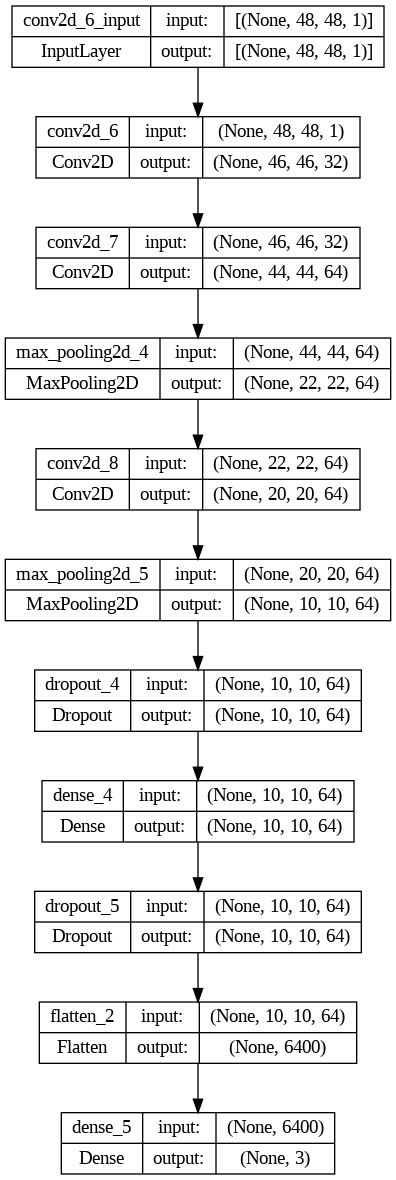

In [ ]:
plot_model(all_mias, to_file='convnet.png', show_shapes=True, show_layer_names=True)
Image(filename='convnet.png')

# Compiling the model

In [ ]:
# # set optmizer and learning rate
adam = Adam(0.001)
all_mias.compile(optimizer=adam,
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [ ]:
# set callbacks
early_stopping = EarlyStopping(patience=5000, restore_best_weights=True)


model_check_point = ModelCheckpoint(filepath= './',
                                    monitor='val_loss', verbose=1,
                                    save_best_only=True,
                                    save_weights_only=False,
                                    mode='auto', save_freq='epoch')

# fit the model
hist = all_mias.fit(train_data,
                    validation_data=test_data,
                    epochs=5000,
                    callbacks=[early_stopping, model_check_point])

Epoch 1/5000
14/16 [=========================>....] - ETA: 0s - loss: 1.0040 - accuracy: 0.4174
Epoch 1: val_loss improved from inf to 1.00797, saving model to ./


16/16 [==============================] - 2s 152ms/step - loss: 1.0072 - accuracy: 0.4206 - val_loss: 1.0080 - val_accuracy: 0.3869
Epoch 2/5000
16/16 [==============================] - ETA: 0s - loss: 1.0000 - accuracy: 0.4385
Epoch 2: val_loss did not improve from 1.00797
16/16 [==============================] - 1s 64ms/step - loss: 1.0000 - accuracy: 0.4385 - val_loss: 1.0771 - val_accuracy: 0.4524
Epoch 3/5000
16/16 [==============================] - ETA: 0s - loss: 1.0266 - accuracy: 0.4365
Epoch 3: val_loss did not improve from 1.00797
16/16 [==============================] - 1s 61ms/step - loss: 1.0266 - accuracy: 0.4365 - val_loss: 1.0234 - val_accuracy: 0.3869
Epoch 4/5000
16/16 [==============================] - ETA: 0s - loss: 1.0006 - accuracy: 0.4563
Epoch 4: val_loss did not improve from 1.00797
16/16 [==============================] - 1s 39ms/step - loss: 1.0006 - accuracy: 0.4563 - val_loss: 1.0173 - val_accuracy: 0.3869
Epoch 5/5000
16/16 [==============================

16/16 [==============================] - 2s 117ms/step - loss: 1.0144 - accuracy: 0.4643 - val_loss: 0.9849 - val_accuracy: 0.4643
Epoch 6/5000
15/16 [===========================>..] - ETA: 0s - loss: 1.0132 - accuracy: 0.3941
Epoch 6: val_loss did not improve from 0.98494
16/16 [==============================] - 1s 39ms/step - loss: 1.0018 - accuracy: 0.3988 - val_loss: 0.9983 - val_accuracy: 0.3869
Epoch 7/5000
14/16 [=========================>....] - ETA: 0s - loss: 1.0040 - accuracy: 0.4219
Epoch 7: val_loss did not improve from 0.98494
16/16 [==============================] - 1s 38ms/step - loss: 0.9924 - accuracy: 0.4365 - val_loss: 0.9918 - val_accuracy: 0.4464
Epoch 8/5000
16/16 [==============================] - ETA: 0s - loss: 1.0037 - accuracy: 0.3968
Epoch 8: val_loss did not improve from 0.98494
16/16 [==============================] - 1s 37ms/step - loss: 1.0037 - accuracy: 0.3968 - val_loss: 1.0234 - val_accuracy: 0.4345
Epoch 9/5000
16/16 [==============================

16/16 [==============================] - 2s 116ms/step - loss: 0.9465 - accuracy: 0.4484 - val_loss: 0.9848 - val_accuracy: 0.4464
Epoch 23/5000
15/16 [===========================>..] - ETA: 0s - loss: 0.9344 - accuracy: 0.4396
Epoch 23: val_loss improved from 0.98479 to 0.94638, saving model to ./


16/16 [==============================] - 2s 133ms/step - loss: 0.9308 - accuracy: 0.4464 - val_loss: 0.9464 - val_accuracy: 0.5060
Epoch 24/5000
15/16 [===========================>..] - ETA: 0s - loss: 0.9375 - accuracy: 0.4563
Epoch 24: val_loss did not improve from 0.94638
16/16 [==============================] - 1s 38ms/step - loss: 0.9391 - accuracy: 0.4524 - val_loss: 0.9876 - val_accuracy: 0.4167
Epoch 25/5000
16/16 [==============================] - ETA: 0s - loss: 0.9337 - accuracy: 0.4583
Epoch 25: val_loss did not improve from 0.94638
16/16 [==============================] - 1s 37ms/step - loss: 0.9337 - accuracy: 0.4583 - val_loss: 0.9703 - val_accuracy: 0.4762
Epoch 26/5000
14/16 [=========================>....] - ETA: 0s - loss: 0.9204 - accuracy: 0.4773
Epoch 26: val_loss did not improve from 0.94638
16/16 [==============================] - 1s 37ms/step - loss: 0.9278 - accuracy: 0.4683 - val_loss: 0.9809 - val_accuracy: 0.4405
Epoch 27/5000
14/16 [=======================

16/16 [==============================] - 2s 113ms/step - loss: 0.9162 - accuracy: 0.4742 - val_loss: 0.9393 - val_accuracy: 0.4762
Epoch 28/5000
15/16 [===========================>..] - ETA: 0s - loss: 0.9118 - accuracy: 0.4767
Epoch 28: val_loss did not improve from 0.93930
16/16 [==============================] - 1s 36ms/step - loss: 0.9131 - accuracy: 0.4742 - val_loss: 0.9452 - val_accuracy: 0.4524
Epoch 29/5000
16/16 [==============================] - ETA: 0s - loss: 0.9032 - accuracy: 0.4742
Epoch 29: val_loss improved from 0.93930 to 0.93784, saving model to ./


16/16 [==============================] - 2s 158ms/step - loss: 0.9032 - accuracy: 0.4742 - val_loss: 0.9378 - val_accuracy: 0.4702
Epoch 30/5000
16/16 [==============================] - ETA: 0s - loss: 0.9251 - accuracy: 0.4405
Epoch 30: val_loss did not improve from 0.93784
16/16 [==============================] - 1s 64ms/step - loss: 0.9251 - accuracy: 0.4405 - val_loss: 0.9794 - val_accuracy: 0.4881
Epoch 31/5000
16/16 [==============================] - ETA: 0s - loss: 0.9237 - accuracy: 0.4940
Epoch 31: val_loss did not improve from 0.93784
16/16 [==============================] - 1s 47ms/step - loss: 0.9237 - accuracy: 0.4940 - val_loss: 0.9930 - val_accuracy: 0.5060
Epoch 32/5000
16/16 [==============================] - ETA: 0s - loss: 0.9311 - accuracy: 0.4722
Epoch 32: val_loss improved from 0.93784 to 0.92586, saving model to ./


16/16 [==============================] - 2s 113ms/step - loss: 0.9311 - accuracy: 0.4722 - val_loss: 0.9259 - val_accuracy: 0.4762
Epoch 33/5000
16/16 [==============================] - ETA: 0s - loss: 0.8917 - accuracy: 0.4742
Epoch 33: val_loss did not improve from 0.92586
16/16 [==============================] - 1s 36ms/step - loss: 0.8917 - accuracy: 0.4742 - val_loss: 0.9405 - val_accuracy: 0.5179
Epoch 34/5000
16/16 [==============================] - ETA: 0s - loss: 0.9123 - accuracy: 0.4544
Epoch 34: val_loss did not improve from 0.92586
16/16 [==============================] - 1s 37ms/step - loss: 0.9123 - accuracy: 0.4544 - val_loss: 0.9783 - val_accuracy: 0.4345
Epoch 35/5000
16/16 [==============================] - ETA: 0s - loss: 0.8842 - accuracy: 0.4722
Epoch 35: val_loss improved from 0.92586 to 0.90044, saving model to ./


16/16 [==============================] - 2s 114ms/step - loss: 0.8842 - accuracy: 0.4722 - val_loss: 0.9004 - val_accuracy: 0.5238
Epoch 36/5000
15/16 [===========================>..] - ETA: 0s - loss: 0.8916 - accuracy: 0.4470
Epoch 36: val_loss did not improve from 0.90044
16/16 [==============================] - 1s 37ms/step - loss: 0.8881 - accuracy: 0.4484 - val_loss: 0.9447 - val_accuracy: 0.4464
Epoch 37/5000
16/16 [==============================] - ETA: 0s - loss: 0.8881 - accuracy: 0.5020
Epoch 37: val_loss did not improve from 0.90044
16/16 [==============================] - 1s 37ms/step - loss: 0.8881 - accuracy: 0.5020 - val_loss: 0.9535 - val_accuracy: 0.5119
Epoch 38/5000
16/16 [==============================] - ETA: 0s - loss: 0.8814 - accuracy: 0.5040
Epoch 38: val_loss did not improve from 0.90044
16/16 [==============================] - 1s 38ms/step - loss: 0.8814 - accuracy: 0.5040 - val_loss: 0.9132 - val_accuracy: 0.4583
Epoch 39/5000
16/16 [=======================

16/16 [==============================] - 3s 176ms/step - loss: 0.8714 - accuracy: 0.4702 - val_loss: 0.8791 - val_accuracy: 0.4940
Epoch 41/5000
16/16 [==============================] - ETA: 0s - loss: 0.8776 - accuracy: 0.4881
Epoch 41: val_loss improved from 0.87911 to 0.85789, saving model to ./


Streaming output truncated to the last 5000 lines.
Epoch 3751/5000
15/16 [===========================>..] - ETA: 0s - loss: 0.1128 - accuracy: 0.9597
Epoch 3751: val_loss did not improve from 0.85789
16/16 [==============================] - 1s 59ms/step - loss: 0.1152 - accuracy: 0.9603 - val_loss: 5.2975 - val_accuracy: 0.7679
Epoch 3752/5000
15/16 [===========================>..] - ETA: 0s - loss: 0.0909 - accuracy: 0.9682
Epoch 3752: val_loss did not improve from 0.85789
16/16 [==============================] - 1s 61ms/step - loss: 0.0996 - accuracy: 0.9603 - val_loss: 4.9951 - val_accuracy: 0.7381
Epoch 3753/5000
15/16 [===========================>..] - ETA: 0s - loss: 0.1293 - accuracy: 0.9492
Epoch 3753: val_loss did not improve from 0.85789
16/16 [==============================] - 1s 71ms/step - loss: 0.1385 - accuracy: 0.9484 - val_loss: 5.9520 - val_accuracy: 0.7857
Epoch 3754/5000
16/16 [==============================] - ETA: 0s - loss: 0.1179 - accuracy: 0.9623
Epoch 3754: v

# Making Predictions

In [ ]:
# predictions
predictions = all_mias.predict(test_data)
predicted = [np.argmax(w) for w in predictions]
expected = test_data.labels


# Evaluation Results
loss_value , accuracy = all_mias.evaluate(train_data)

print(f'Test loss_value: {loss_value}')
print(f'Test accuracy: {accuracy}')

16/16 [==============================] - 1s 36ms/step - loss: 0.0464 - accuracy: 0.9881
Test loss_value: 0.04635791853070259
Test accuracy: 0.988095223903656


# Confusion Matrix

In [ ]:
confusion_matrix(expected, predicted)

array([[12,  5,  8],
       [ 5, 57, 16],
       [ 0, 10, 55]])

# Classification Report

In [ ]:
# B, M or A
print(f'Classes: {test_data.class_indices}\n')
print(classification_report(expected, predicted))

Classes: {'A': 0, 'B': 1, 'M': 2}

              precision    recall  f1-score   support

           0       0.71      0.48      0.57        25
           1       0.79      0.73      0.76        78
           2       0.70      0.85      0.76        65

    accuracy                           0.74       168
   macro avg       0.73      0.69      0.70       168
weighted avg       0.74      0.74      0.73       168



# Results

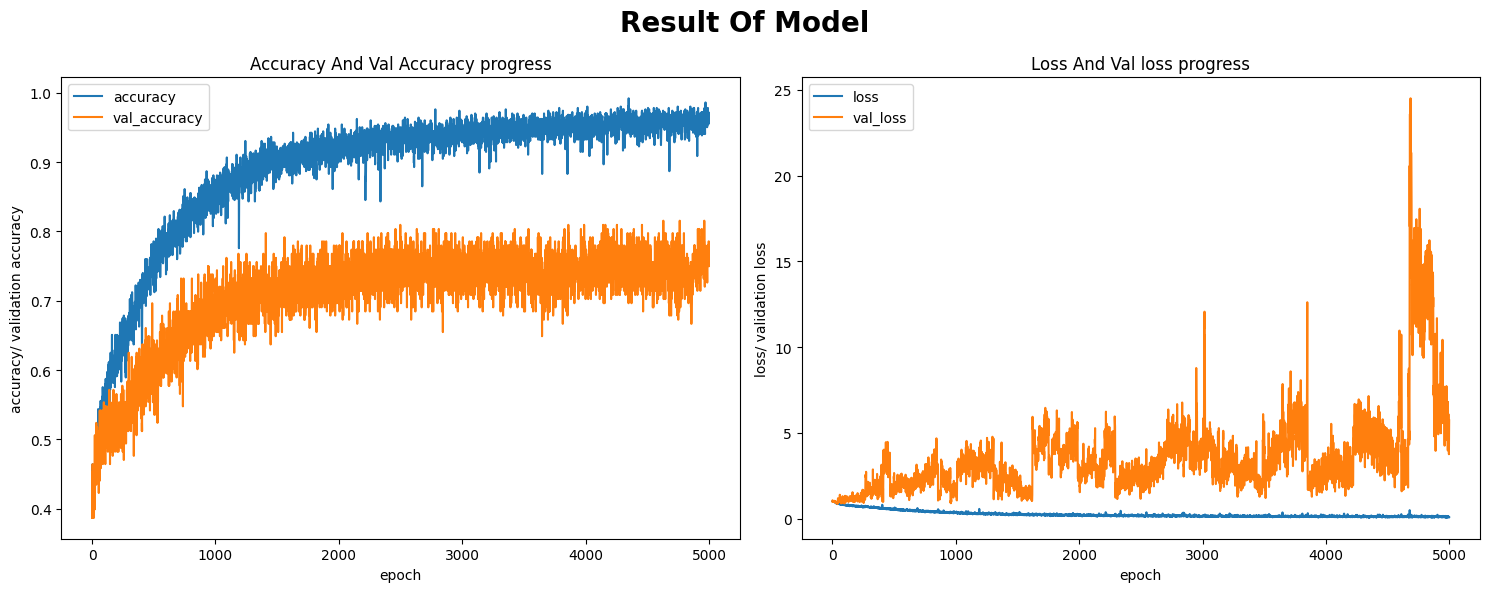

In [ ]:
results_plot = hp.plot_results(hist.history['accuracy'],
                               hist.history['val_accuracy'],
                               hist.history['loss'],
                               hist.history['val_loss'])

In [ ]:
# enter data to the final results dataframe
results_all_mias = classification_report(expected, predicted, output_dict=True)
# add entry to the final_results
all_mias_malignant = results_all_mias['1']
all_mias_malignant
final_results.loc['all_full_bal'] = (accuracy,
                                     all_mias_malignant['precision'],
                                     all_mias_malignant['recall'],
                                     all_mias_malignant['f1-score'])
final_results

test_accuracy  precision    recall  f1-score
calcifications        0.938889   0.750000  0.923077  0.827586
masses_full_bal       0.976852   0.870968  0.794118  0.830769
all_full_bal          0.988095   0.791667  0.730769  0.760000

# Checking Wrong Predictions

In [ ]:
# checking wrong predictions
predictions = all_mias.predict(test_data)

# check the probabilities for the first sample
for index, probability in enumerate(predictions[0]):
    print(f'{index}: {probability:.10%}')

6/6 [==============================] - 0s 20ms/step
0: 0.0956534699%
1: 95.3702926636%
2: 4.5340500772%


In [ ]:
images = all_mias_full.p_matrix

In [ ]:
wrong_predictions = []

for i, (p,e) in enumerate(zip(predictions, test_data.labels)):
    predicted, expected = np.argmax(p), np.argmax(e)
    # create something to keep the same index from calcifications_balanced
    # and wrong predictions
    if predicted != expected:
        wrong_predictions.append(
            (i, images[i], predicted, expected))

In [ ]:
len(wrong_predictions)

145

In [ ]:
a,b,c,d = wrong_predictions[15]

In [ ]:
test = all_mias_full.iloc[a].loc['p_matrix'] == b

In [ ]:
hp.display_probabilities(predictions[15])

0: 84.2268288136%
1: 13.1536543369%
2: 2.6195155457%


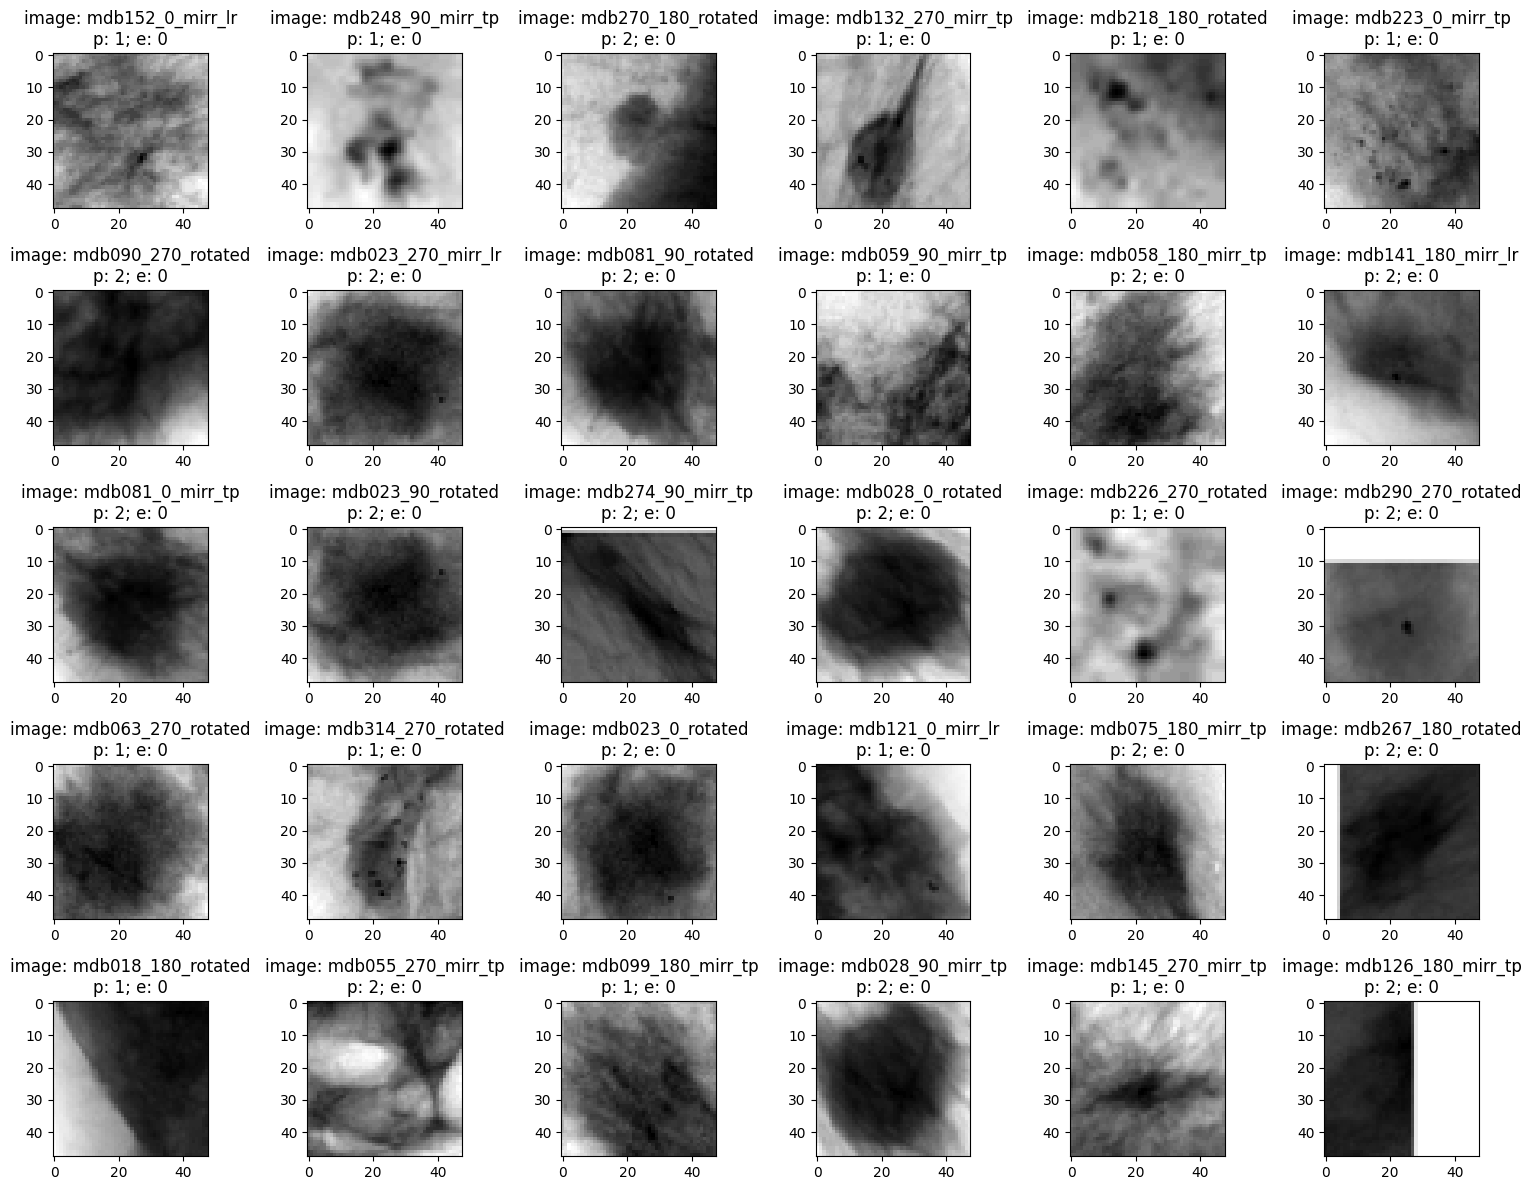

In [ ]:
figure, axes = plt.subplots(nrows=5, ncols=6, figsize=(16, 12))

for axes, item in zip(axes.ravel(), wrong_predictions):
    index, image, predicted, expected = item
    axes.imshow(image, cmap=plt.cm.gray_r)
    axes.set_title(
                    f'image: {all_mias_full.iloc[index].name}\np: {predicted}; e: {expected}'
                   )
    plt.tight_layout()

<Axes: >

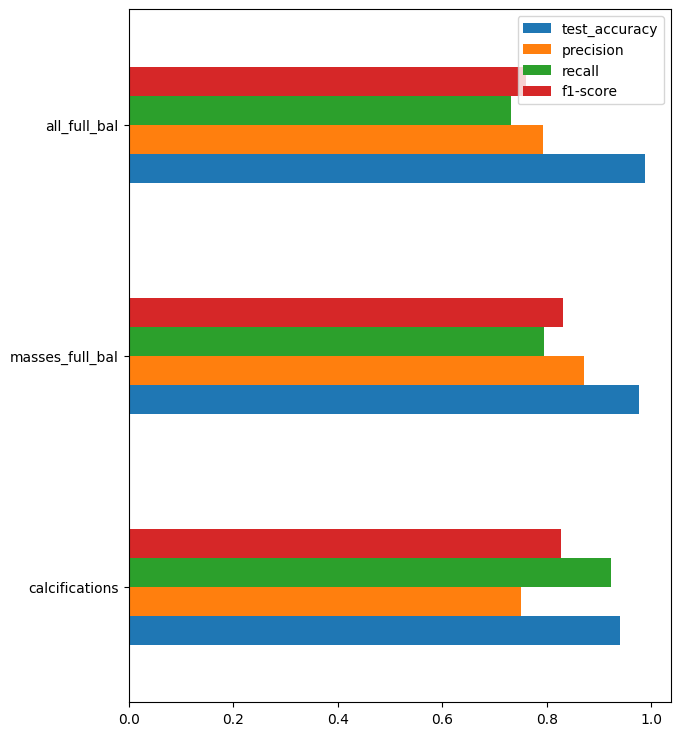

In [ ]:
final_results.plot(kind='barh', figsize=(7, 9), legend={'reverse'} )